In [ ]:
#####Note this notebook uses the tuning results from "BCI comp IV 2a - CNN tuning.ipynb"

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import keras_tuner as kt
from scipy import signal
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Lambda, AveragePooling2D, Softmax, ReLU, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
from math import floor,inf
from sklearn.utils import shuffle

In [2]:
data_folder = 'BBCI competition IV 2a'  ###location of .mat files for each subject, change file path if running notebook from...
                                        ###...different directory to data folder
subject_files = os.listdir(data_folder)

In [3]:
subject_files

['A01E.mat',
 'A01T.mat',
 'A02E.mat',
 'A02T.mat',
 'A03E.mat',
 'A03T.mat',
 'A04E.mat',
 'A04T.mat',
 'A05E.mat',
 'A05T.mat',
 'A06E.mat',
 'A06T.mat',
 'A07E.mat',
 'A07T.mat',
 'A08E.mat',
 'A08T.mat',
 'A09E.mat',
 'A09T.mat']

In [4]:
####Create dataset of only the 4s in the trials where MI was being performed.
def create_4sec_data(subject,dataset):
    data_folder = 'BBCI competition IV 2a'
    file = 'A0' + str(subject) + dataset[0] + '.mat'
    file_path = os.path.join(data_folder, file )
    print(file_path)
    data = sio.loadmat(file_path)['data']
    x=[]
    y=[]
    if file == 'A04T.mat':
        lower_lim = 1
        upper_lim = 7
    else:
        lower_lim = 3
        upper_lim = 9
    for s in range(lower_lim, upper_lim):
        eeg = pd.DataFrame(np.transpose(data[0,s][0,0][0])[:22])
        cues = data[0,s][0,0][1]
        mi = data[0,s][0,0][2]
        for i in range(48):
            start = cues[i][0] + 500
            end = start + 1000
            mi_data = eeg.iloc[:,start:end]
            x.append(np.array(mi_data))
            if mi[i][0] == 3:
                y.append(0)
            elif mi[i][0] == 4:
                y.append(3)
            else:
                y.append(mi[i][0])
            
    return np.array(x), np.array(y)

In [5]:
###Function to segment and filter 4s data into 2s segments
def filt_and_seg(x_4sec, y_4sec, samples, overlap):
    unique = floor((1-overlap)*samples)
    b,a = signal.butter(2, Wn = [48,52], btype = 'bandstop', fs = 250)
    d,c = signal.butter(2, Wn = [4,38], btype = 'bandpass', fs = 250)
    x=[]
    y=[]
    count = 0
    for trial in x_4sec:
        data = trial
        label = y_4sec[count]
        for div in range(int(data.size//(data.shape[0]*unique))):
            if div*unique +samples <= data.size/data.shape[0]:
                array = np.ndarray((22,samples))
                for i in range(22):
                    notch_filt = signal.filtfilt(b,a, data[i][div*unique:div*unique + samples], padtype='even')
                    bp_filt = signal.filtfilt(d,c, notch_filt, padtype='even')
                    array[i] = bp_filt
                x.append(array)
                y.append(label)
        count+=1
    x=np.array(x)
    x=x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
    x, y = shuffle(x,y, random_state=42)
    return x,y
        

In [6]:
###Function used to build the tuned models and set up hyperparameter search spaces during tuning
def build_model(hp):
    model = Sequential()
    
    hp_filters = hp.Int('Filters', min_value=10,max_value=160,step=10)
    hp_kern_len = hp.Int('Kernel1 Length', min_value=10, max_value=250, step=10)
    model.add(Conv2D(filters=hp_filters, kernel_size=(1,hp_kern_len), input_shape=(x_train.shape[1],x_train.shape[2],1))) #, activation = 'relu'))
    model.add(Conv2D(filters=hp_filters, kernel_size=(22,1), activation = 'elu'))
    hp_momentum = hp.Float('Momentum', min_value=0.05, max_value=0.95, step=0.05)
    model.add(BatchNormalization(momentum=hp_momentum, epsilon = 1e-05))
    model.add(Lambda(lambda x: x**2))
    hp_pool_len = hp.Int('Pooling Length', min_value=10, max_value=250, step=10)
    hp_strides = hp.Int('Pooling Strides', min_value = 5, max_value=50, step=5)
    model.add(AveragePooling2D(pool_size=(1,hp_pool_len),strides=hp_strides))
    
    model.add(Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 1e-6, inf))))
    hp_dropout = hp.Float('Dropout Rate', min_value=0.1, max_value=0.9, step = 0.1)
    model.add(Dropout(hp_dropout))
    
    '''model.add(Conv2D(filters=4, kernel_size=(1,69))) #, activation = 'relu'))       
    
    model.add(Softmax())
    
    model.add(Lambda(lambda x: tf.squeeze(x, [1,2])))'''   ####Equivalent to flattening which was used instead
    
    model.add(Flatten())

    model.add(Dense(4, activation = 'softmax'))
    
    loss_fn = 'categorical_crossentropy'
    
    hp_learn_rate = hp.Choice('Learning Rate', values=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6])
    
    
    adam = tf.keras.optimizers.Adam(learning_rate=hp_learn_rate)
    model.compile(loss = loss_fn, optimizer=adam, metrics=['accuracy'], )  # other metrics at keras.io/metrics

    return model

In [7]:
####Function to build models using the best hyperparameters obtained during tuning
def build_tuned_model(tuner):
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    tuned_model = tuner.hypermodel.build(best_hps)
    tuned_model.summary()
    return tuned_model

{'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}
BBCI competition IV 2a\A01T.mat
BBCI competition IV 2a\A01E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S1\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S1\tuner0.json
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 491, 50)        55050     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 491, 50)        200       
____________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.746     0.713     0.730       792
   Left Hand      0.865     0.862     0.863       792
  Right Hand      0.908     0.847     0.877       792
      Tongue      0.711     0.792     0.749       792

    accuracy                          0.804      3168
   macro avg      0.807     0.804     0.805      3168
weighted avg      0.807     0.804     0.805      3168

[[565  14   6 207]
 [ 13 683  59  37]
 [ 26  84 671  11]
 [153   9   3 627]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5020 - accuracy: 0.8037
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 491, 50)        55050     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.711     0.828     0.765       792
   Left Hand      0.855     0.828     0.842       792
  Right Hand      0.866     0.851     0.859       792
      Tongue      0.789     0.698     0.741       792

    accuracy                          0.801      3168
   macro avg      0.805     0.801     0.802      3168
weighted avg      0.805     0.801     0.802      3168

[[656  14  13 109]
 [ 28 656  90  18]
 [ 12  85 674  21]
 [226  12   1 553]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4935 - accuracy: 0.8015
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 491, 50)        55050     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.738     0.747     0.743       792
   Left Hand      0.800     0.924     0.858       792
  Right Hand      0.920     0.828     0.872       792
      Tongue      0.775     0.722     0.748       792

    accuracy                          0.806      3168
   macro avg      0.808     0.806     0.805      3168
weighted avg      0.808     0.806     0.805      3168

[[592  43  12 145]
 [  8 732  43   9]
 [ 21 103 656  12]
 [181  37   2 572]]
99/99 [==============================] - 1s 6ms/step - loss: 0.4880 - accuracy: 0.8056
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 491, 50)        55050     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.768     0.808     0.788       792
   Left Hand      0.823     0.874     0.848       792
  Right Hand      0.895     0.841     0.867       792
      Tongue      0.801     0.759     0.780       792

    accuracy                          0.820      3168
   macro avg      0.822     0.820     0.820      3168
weighted avg      0.822     0.820     0.820      3168

[[640  22  11 119]
 [ 12 692  63  25]
 [ 11 110 666   5]
 [170  17   4 601]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4744 - accuracy: 0.8204
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 491, 50)        55050     
_________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0361 - accuracy: 0.9927 - val_loss: 0.6549 - val_accuracy: 0.7929
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0376 - accuracy: 0.9915 - val_loss: 0.6524 - val_accuracy: 0.7857
Epoch 103/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0349 - accuracy: 0.9940 - val_loss: 0.5983 - val_accuracy: 0.8056
Epoch 104/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0305 - accuracy: 0.9953 - val_loss: 0.7156 - val_accuracy: 0.7759


C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.758     0.813     0.784       792
   Left Hand      0.858     0.870     0.864       792
  Right Hand      0.907     0.833     0.868       792
      Tongue      0.767     0.763     0.765       792

    accuracy                          0.820      3168
   macro avg      0.822     0.820     0.820      3168
weighted avg      0.822     0.820     0.820      3168

[[644  11  12 125]
 [  9 689  54  40]
 [ 22  92 660  18]
 [175  11   2 604]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4737 - accuracy: 0.8198
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 491, 50)        55050     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.766     0.707     0.735       792
   Left Hand      0.820     0.871     0.845       792
  Right Hand      0.887     0.842     0.864       792
      Tongue      0.735     0.783     0.758       792

    accuracy                          0.801      3168
   macro avg      0.802     0.801     0.801      3168
weighted avg      0.802     0.801     0.801      3168

[[560  26   9 197]
 [ 11 690  72  19]
 [ 18  99 667   8]
 [142  26   4 620]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5095 - accuracy: 0.8008
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 491, 50)        55050     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.735     0.770     0.752       792
   Left Hand      0.880     0.809     0.843       792
  Right Hand      0.860     0.881     0.870       792
      Tongue      0.757     0.763     0.760       792

    accuracy                          0.806      3168
   macro avg      0.808     0.806     0.806      3168
weighted avg      0.808     0.806     0.806      3168

[[610  12  10 160]
 [ 23 641 103  25]
 [ 24  61 698   9]
 [173  14   1 604]]
99/99 [==============================] - 1s 5ms/step - loss: 0.4838 - accuracy: 0.8059
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 491, 50)        55050     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.718     0.790     0.752       792
   Left Hand      0.798     0.869     0.832       792
  Right Hand      0.886     0.833     0.859       792
      Tongue      0.775     0.674     0.721       792

    accuracy                          0.792      3168
   macro avg      0.794     0.792     0.791      3168
weighted avg      0.794     0.792     0.791      3168

[[626  24  13 129]
 [ 18 688  67  19]
 [ 11 114 660   7]
 [217  36   5 534]]
99/99 [==============================] - 0s 4ms/step - loss: 0.5332 - accuracy: 0.7917
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 491, 50)        55050     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.757     0.742     0.750       792
   Left Hand      0.824     0.888     0.855       792
  Right Hand      0.892     0.867     0.880       792
      Tongue      0.768     0.745     0.756       792

    accuracy                          0.811      3168
   macro avg      0.810     0.811     0.810      3168
weighted avg      0.810     0.811     0.810      3168

[[588  42  10 152]
 [  4 703  72  13]
 [ 12  80 687  13]
 [173  28   1 590]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4852 - accuracy: 0.8106
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.736     0.769     0.752       792
   Left Hand      0.851     0.802     0.826       792
  Right Hand      0.850     0.864     0.857       792
      Tongue      0.756     0.754     0.755       792

    accuracy                          0.797      3168
   macro avg      0.798     0.797     0.797      3168
weighted avg      0.798     0.797     0.797      3168

[[609  10  16 157]
 [ 30 635 103  24]
 [ 11  85 684  12]
 [177  16   2 597]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4981 - accuracy: 0.7970
BBCI competition IV 2a\A02T.mat
BBCI competition IV 2a\A02E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S2\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S2\tuner0.json
Model: "seq

Epoch 41/400
99/99 [==============================] - 1s 9ms/step - loss: 0.1675 - accuracy: 0.9536 - val_loss: 2.3442 - val_accuracy: 0.4290
Epoch 42/400
99/99 [==============================] - 1s 9ms/step - loss: 0.1500 - accuracy: 0.9618 - val_loss: 3.1831 - val_accuracy: 0.4369
Epoch 43/400
99/99 [==============================] - 1s 9ms/step - loss: 0.1352 - accuracy: 0.9675 - val_loss: 2.7671 - val_accuracy: 0.4268
Epoch 44/400
99/99 [==============================] - 1s 9ms/step - loss: 0.1417 - accuracy: 0.9596 - val_loss: 3.2027 - val_accuracy: 0.4261
Epoch 45/400
99/99 [==============================] - 1s 9ms/step - loss: 0.1317 - accuracy: 0.9628 - val_loss: 2.5817 - val_accuracy: 0.4410
Epoch 46/400
99/99 [==============================] - 1s 9ms/step - loss: 0.1276 - accuracy: 0.9697 - val_loss: 2.3657 - val_accuracy: 0.4564
Epoch 47/400
99/99 [==============================] - 1s 9ms/step - loss: 0.1172 - accuracy: 0.9665 - val_loss: 3.2877 - val_accuracy: 0.4227
Epoch 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.504     0.794     0.616       792
   Left Hand      0.300     0.346     0.321       792
  Right Hand      0.349     0.218     0.269       792
      Tongue      0.409     0.263     0.320       792

    accuracy                          0.405      3168
   macro avg      0.390     0.405     0.381      3168
weighted avg      0.390     0.405     0.381      3168

[[629  65  43  55]
 [269 274 143 106]
 [183 296 173 140]
 [168 279 137 208]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2973 - accuracy: 0.4053
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.514     0.694     0.590       792
   Left Hand      0.296     0.453     0.358       792
  Right Hand      0.369     0.192     0.252       792
      Tongue      0.400     0.239     0.299       792

    accuracy                          0.395      3168
   macro avg      0.395     0.395     0.375      3168
weighted avg      0.395     0.395     0.375      3168

[[550 154  28  60]
 [202 359 123 108]
 [158 366 152 116]
 [161 333 109 189]]
99/99 [==============================] - 1s 5ms/step - loss: 1.2873 - accuracy: 0.3946
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.497     0.751     0.598       792
   Left Hand      0.298     0.326     0.311       792
  Right Hand      0.354     0.254     0.296       792
      Tongue      0.406     0.275     0.328       792

    accuracy                          0.402      3168
   macro avg      0.389     0.402     0.383      3168
weighted avg      0.389     0.402     0.383      3168

[[595  63  56  78]
 [244 258 167 123]
 [189 284 201 118]
 [169 262 143 218]]
99/99 [==============================] - 1s 5ms/step - loss: 1.2818 - accuracy: 0.4015
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.581     0.669     0.622       792
   Left Hand      0.292     0.585     0.389       792
  Right Hand      0.374     0.150     0.214       792
      Tongue      0.406     0.181     0.250       792

    accuracy                          0.396      3168
   macro avg      0.413     0.396     0.369      3168
weighted avg      0.413     0.396     0.369      3168

[[530 183  22  57]
 [148 463 109  72]
 [111 482 119  80]
 [123 458  68 143]]
99/99 [==============================] - 0s 4ms/step - loss: 1.3318 - accuracy: 0.3961
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.594     0.629     0.611       792
   Left Hand      0.320     0.278     0.297       792
  Right Hand      0.298     0.393     0.339       792
      Tongue      0.455     0.345     0.392       792

    accuracy                          0.411      3168
   macro avg      0.417     0.411     0.410      3168
weighted avg      0.417     0.411     0.410      3168

[[498  68 141  85]
 [142 220 314 116]
 [ 95 260 311 126]
 [104 139 276 273]]
99/99 [==============================] - 0s 4ms/step - loss: 1.2729 - accuracy: 0.4110
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.486     0.814     0.609       792
   Left Hand      0.281     0.184     0.223       792
  Right Hand      0.388     0.438     0.412       792
      Tongue      0.443     0.240     0.311       792

    accuracy                          0.419      3168
   macro avg      0.400     0.419     0.389      3168
weighted avg      0.400     0.419     0.389      3168

[[645  33  68  46]
 [269 146 272 105]
 [208 149 347  88]
 [204 191 207 190]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2871 - accuracy: 0.4192
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.653     0.542     0.592       792
   Left Hand      0.322     0.419     0.364       792
  Right Hand      0.431     0.247     0.314       792
      Tongue      0.435     0.563     0.491       792

    accuracy                          0.443      3168
   macro avg      0.460     0.443     0.440      3168
weighted avg      0.460     0.443     0.440      3168

[[429 161  63 139]
 [103 332 137 220]
 [ 60 316 196 220]
 [ 65 222  59 446]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2630 - accuracy: 0.4429
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.606     0.622     0.614       792
   Left Hand      0.330     0.472     0.389       792
  Right Hand      0.445     0.236     0.309       792
      Tongue      0.459     0.465     0.462       792

    accuracy                          0.449      3168
   macro avg      0.460     0.449     0.443      3168
weighted avg      0.460     0.449     0.443      3168

[[493 159  32 108]
 [139 374 119 160]
 [ 89 350 187 166]
 [ 93 249  82 368]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2871 - accuracy: 0.4489
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.574     0.713     0.636       792
   Left Hand      0.316     0.441     0.368       792
  Right Hand      0.416     0.288     0.340       792
      Tongue      0.497     0.333     0.399       792

    accuracy                          0.444      3168
   macro avg      0.451     0.444     0.436      3168
weighted avg      0.451     0.444     0.436      3168

[[565 133  50  44]
 [171 349 156 116]
 [122 335 228 107]
 [126 288 114 264]]
99/99 [==============================] - 1s 5ms/step - loss: 1.2252 - accuracy: 0.4438
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.606     0.630     0.618       792
   Left Hand      0.410     0.312     0.354       792
  Right Hand      0.437     0.399     0.417       792
      Tongue      0.456     0.587     0.514       792

    accuracy                          0.482      3168
   macro avg      0.477     0.482     0.476      3168
weighted avg      0.477     0.482     0.476      3168

[[499  56  90 147]
 [135 247 196 214]
 [ 79 204 316 193]
 [110  96 121 465]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2247 - accuracy: 0.4820
BBCI competition IV 2a\A03T.mat
BBCI competition IV 2a\A03E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S3\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S3\tuner0.json
Model: "seq

99/99 [==============================] - 1s 8ms/step - loss: 0.4690 - accuracy: 0.8194 - val_loss: 0.4790 - val_accuracy: 0.8112
Epoch 98/400
99/99 [==============================] - 1s 8ms/step - loss: 0.5005 - accuracy: 0.8122 - val_loss: 0.4076 - val_accuracy: 0.8403
Epoch 99/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4618 - accuracy: 0.8210 - val_loss: 0.4124 - val_accuracy: 0.8384
Epoch 100/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4772 - accuracy: 0.8141 - val_loss: 0.4705 - val_accuracy: 0.8163
Epoch 101/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4487 - accuracy: 0.8305 - val_loss: 0.4707 - val_accuracy: 0.8172
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4679 - accuracy: 0.8235 - val_loss: 0.4365 - val_accuracy: 0.8169
Epoch 103/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4588 - accuracy: 0.8232 - val_loss: 0.4316 - val_accuracy: 0.8273
Epoch 104/400
9

Epoch 211/400
99/99 [==============================] - 1s 10ms/step - loss: 0.3977 - accuracy: 0.8441 - val_loss: 0.4283 - val_accuracy: 0.8289
Epoch 212/400
99/99 [==============================] - 1s 10ms/step - loss: 0.3903 - accuracy: 0.8488 - val_loss: 0.5258 - val_accuracy: 0.8062
Epoch 213/400
99/99 [==============================] - 1s 10ms/step - loss: 0.3570 - accuracy: 0.8658 - val_loss: 0.3922 - val_accuracy: 0.8491
Epoch 214/400
99/99 [==============================] - 1s 10ms/step - loss: 0.3814 - accuracy: 0.8539 - val_loss: 0.3945 - val_accuracy: 0.8431
Epoch 215/400
99/99 [==============================] - 1s 10ms/step - loss: 0.3574 - accuracy: 0.8699 - val_loss: 0.4518 - val_accuracy: 0.8194
Epoch 216/400
99/99 [==============================] - 1s 10ms/step - loss: 0.3858 - accuracy: 0.8570 - val_loss: 0.3725 - val_accuracy: 0.8466
Epoch 217/400
99/99 [==============================] - 1s 9ms/step - loss: 0.3937 - accuracy: 0.8504 - val_loss: 0.4427 - val_accuracy: 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.848     0.761     0.802       792
   Left Hand      0.921     0.864     0.891       792
  Right Hand      0.853     0.987     0.915       792
      Tongue      0.826     0.831     0.828       792

    accuracy                          0.861      3168
   macro avg      0.862     0.861     0.859      3168
weighted avg      0.862     0.861     0.859      3168

[[603  32  56 101]
 [ 21 684  54  33]
 [  2   3 782   5]
 [ 85  24  25 658]]
99/99 [==============================] - 0s 4ms/step - loss: 0.3559 - accuracy: 0.8608
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4616 - accuracy: 0.8235 - val_loss: 0.4369 - val_accuracy: 0.8141
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4894 - accuracy: 0.8109 - val_loss: 0.4349 - val_accuracy: 0.8283
Epoch 103/400
99/99 [==============================] - 1s 7ms/step - loss: 0.5028 - accuracy: 0.8125 - val_loss: 0.4715 - val_accuracy: 0.8097
Epoch 104/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4647 - accuracy: 0.8254 - val_loss: 0.5045 - val_accuracy: 0.8052
Epoch 105/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4560 - accuracy: 0.8295 - val_loss: 0.4425 - val_accuracy: 0.8217
Epoch 106/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4665 - accuracy: 0.8264 - val_loss: 0.4377 - val_accuracy: 0.8336
Epoch 107/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4775 - accuracy: 0.8201 - val_loss: 0.5259 - val_accuracy: 0.7945

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.848     0.756     0.800       792
   Left Hand      0.893     0.883     0.888       792
  Right Hand      0.882     0.970     0.924       792
      Tongue      0.817     0.833     0.825       792

    accuracy                          0.860      3168
   macro avg      0.860     0.860     0.859      3168
weighted avg      0.860     0.860     0.859      3168

[[599  42  40 111]
 [ 23 699  42  28]
 [  3  12 768   9]
 [ 81  30  21 660]]
99/99 [==============================] - 1s 5ms/step - loss: 0.3582 - accuracy: 0.8605
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

99/99 [==============================] - 1s 8ms/step - loss: 0.4742 - accuracy: 0.8201 - val_loss: 0.4053 - val_accuracy: 0.8384
Epoch 101/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4721 - accuracy: 0.8166 - val_loss: 0.4565 - val_accuracy: 0.8169
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4368 - accuracy: 0.8390 - val_loss: 0.3985 - val_accuracy: 0.8431
Epoch 103/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4930 - accuracy: 0.8084 - val_loss: 0.4420 - val_accuracy: 0.8182
Epoch 104/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4526 - accuracy: 0.8223 - val_loss: 0.4753 - val_accuracy: 0.8112
Epoch 105/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4785 - accuracy: 0.8163 - val_loss: 0.4555 - val_accuracy: 0.8106
Epoch 106/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4738 - accuracy: 0.8223 - val_loss: 0.4055 - val_accuracy: 0.8362
Epoch 107/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.852     0.783     0.816       792
   Left Hand      0.906     0.910     0.908       792
  Right Hand      0.883     0.984     0.931       792
      Tongue      0.853     0.821     0.837       792

    accuracy                          0.874      3168
   macro avg      0.873     0.874     0.873      3168
weighted avg      0.873     0.874     0.873      3168

[[620  36  44  92]
 [ 19 721  35  17]
 [  2   8 779   3]
 [ 87  31  24 650]]
99/99 [==============================] - 0s 3ms/step - loss: 0.3441 - accuracy: 0.8744
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4666 - accuracy: 0.8198 - val_loss: 0.4049 - val_accuracy: 0.8441
Epoch 102/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4743 - accuracy: 0.8210 - val_loss: 0.4906 - val_accuracy: 0.8071
Epoch 103/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4610 - accuracy: 0.8314 - val_loss: 0.4485 - val_accuracy: 0.8122
Epoch 104/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4303 - accuracy: 0.8390 - val_loss: 0.4420 - val_accuracy: 0.8311
Epoch 105/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4720 - accuracy: 0.8242 - val_loss: 0.5552 - val_accuracy: 0.7689
Epoch 106/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4431 - accuracy: 0.8314 - val_loss: 0.4404 - val_accuracy: 0.8267
Epoch 107/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4337 - accuracy: 0.8400 - val_loss: 0.4123 - val_accuracy: 0.8359

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.833     0.785     0.808       792
   Left Hand      0.899     0.885     0.892       792
  Right Hand      0.859     0.989     0.919       792
      Tongue      0.866     0.797     0.830       792

    accuracy                          0.864      3168
   macro avg      0.864     0.864     0.862      3168
weighted avg      0.864     0.864     0.862      3168

[[622  41  58  71]
 [ 26 701  39  26]
 [  1   7 783   1]
 [ 98  31  32 631]]
99/99 [==============================] - 0s 3ms/step - loss: 0.3532 - accuracy: 0.8640
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4801 - accuracy: 0.8232 - val_loss: 0.4423 - val_accuracy: 0.8217
Epoch 102/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4487 - accuracy: 0.8270 - val_loss: 0.4160 - val_accuracy: 0.8311
Epoch 103/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4752 - accuracy: 0.8157 - val_loss: 0.4257 - val_accuracy: 0.8378
Epoch 104/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4976 - accuracy: 0.8100 - val_loss: 0.4277 - val_accuracy: 0.8330
Epoch 105/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4799 - accuracy: 0.8229 - val_loss: 0.4504 - val_accuracy: 0.8150
Epoch 106/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4937 - accuracy: 0.8109 - val_loss: 0.4181 - val_accuracy: 0.8318
Epoch 107/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4847 - accuracy: 0.8119 - val_loss: 0.4124 - val_accuracy: 0.8349

99/99 [==============================] - 1s 7ms/step - loss: 0.3871 - accuracy: 0.8529 - val_loss: 0.3915 - val_accuracy: 0.8472
Epoch 216/400
99/99 [==============================] - 1s 7ms/step - loss: 0.3913 - accuracy: 0.8605 - val_loss: 0.3643 - val_accuracy: 0.8561
Epoch 217/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3666 - accuracy: 0.8640 - val_loss: 0.4450 - val_accuracy: 0.8245
Epoch 218/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3787 - accuracy: 0.8573 - val_loss: 0.4196 - val_accuracy: 0.8333
Epoch 219/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3800 - accuracy: 0.8564 - val_loss: 0.3947 - val_accuracy: 0.8510
Epoch 220/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3756 - accuracy: 0.8567 - val_loss: 0.3951 - val_accuracy: 0.8466
Epoch 221/400
99/99 [==============================] - 1s 7ms/step - loss: 0.3780 - accuracy: 0.8520 - val_loss: 0.4322 - val_accuracy: 0.8371
Epoch 222/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.849     0.795     0.821       792
   Left Hand      0.894     0.870     0.882       792
  Right Hand      0.882     0.976     0.927       792
      Tongue      0.831     0.817     0.824       792

    accuracy                          0.865      3168
   macro avg      0.864     0.865     0.863      3168
weighted avg      0.864     0.865     0.863      3168

[[630  34  35  93]
 [ 17 689  52  34]
 [  1  13 773   5]
 [ 94  35  16 647]]
99/99 [==============================] - 0s 3ms/step - loss: 0.3478 - accuracy: 0.8646
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4745 - accuracy: 0.8242 - val_loss: 0.4552 - val_accuracy: 0.8210
Epoch 102/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4739 - accuracy: 0.8217 - val_loss: 0.4482 - val_accuracy: 0.8267
Epoch 103/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4611 - accuracy: 0.8254 - val_loss: 0.4421 - val_accuracy: 0.8308
Epoch 104/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4265 - accuracy: 0.8362 - val_loss: 0.4275 - val_accuracy: 0.8258
Epoch 105/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4587 - accuracy: 0.8264 - val_loss: 0.4829 - val_accuracy: 0.8084
Epoch 106/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4705 - accuracy: 0.8242 - val_loss: 0.5121 - val_accuracy: 0.7847
Epoch 107/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4850 - accuracy: 0.8125 - val_loss: 0.4236 - val_accuracy: 0.8346

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.856     0.735     0.791       792
   Left Hand      0.900     0.895     0.897       792
  Right Hand      0.841     0.985     0.907       792
      Tongue      0.828     0.807     0.817       792

    accuracy                          0.855      3168
   macro avg      0.856     0.855     0.853      3168
weighted avg      0.856     0.855     0.853      3168

[[582  37  69 104]
 [  9 709  47  27]
 [  1   9 780   2]
 [ 88  33  32 639]]
99/99 [==============================] - 0s 3ms/step - loss: 0.3809 - accuracy: 0.8554
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

99/99 [==============================] - 1s 13ms/step - loss: 0.4549 - accuracy: 0.8229 - val_loss: 0.3805 - val_accuracy: 0.8545
Epoch 101/400
99/99 [==============================] - 1s 13ms/step - loss: 0.4904 - accuracy: 0.8254 - val_loss: 0.5937 - val_accuracy: 0.7778
Epoch 102/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4782 - accuracy: 0.8163 - val_loss: 0.4052 - val_accuracy: 0.8374
Epoch 103/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4503 - accuracy: 0.8267 - val_loss: 0.4411 - val_accuracy: 0.8305
Epoch 104/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4398 - accuracy: 0.8321 - val_loss: 0.4763 - val_accuracy: 0.8125
Epoch 105/400
99/99 [==============================] - 1s 13ms/step - loss: 0.4720 - accuracy: 0.8169 - val_loss: 0.3985 - val_accuracy: 0.8406
Epoch 106/400
99/99 [==============================] - 1s 13ms/step - loss: 0.4419 - accuracy: 0.8267 - val_loss: 0.3671 - val_accuracy: 0.8598
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 10ms/step - loss: 0.4332 - accuracy: 0.8352 - val_loss: 0.3755 - val_accuracy: 0.8545
Epoch 158/400
99/99 [==============================] - 1s 10ms/step - loss: 0.4401 - accuracy: 0.8299 - val_loss: 0.3873 - val_accuracy: 0.8485
Epoch 159/400
99/99 [==============================] - 1s 10ms/step - loss: 0.4106 - accuracy: 0.8419 - val_loss: 0.3533 - val_accuracy: 0.8640
Epoch 160/400
99/99 [==============================] - 1s 10ms/step - loss: 0.3907 - accuracy: 0.8501 - val_loss: 0.3923 - val_accuracy: 0.8409
Epoch 161/400
99/99 [==============================] - 1s 10ms/step - loss: 0.3992 - accuracy: 0.8469 - val_loss: 0.3707 - val_accuracy: 0.8602
Epoch 162/400
99/99 [==============================] - 1s 10ms/step - loss: 0.4085 - accuracy: 0.8501 - val_loss: 0.3819 - val_accuracy: 0.8561
Epoch 163/400
99/99 [==============================] - 1s 9ms/step - loss: 0.4187 - accuracy: 0.8479 - val_loss: 0.4690 - val_accuracy: 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.868     0.803     0.834       792
   Left Hand      0.917     0.883     0.900       792
  Right Hand      0.869     0.992     0.926       792
      Tongue      0.865     0.838     0.851       792

    accuracy                          0.879      3168
   macro avg      0.880     0.879     0.878      3168
weighted avg      0.880     0.879     0.878      3168

[[636  34  47  75]
 [ 16 699  50  27]
 [  2   2 786   2]
 [ 79  27  22 664]]
99/99 [==============================] - 0s 3ms/step - loss: 0.3232 - accuracy: 0.8791
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

99/99 [==============================] - 1s 12ms/step - loss: 0.4845 - accuracy: 0.8128 - val_loss: 0.4286 - val_accuracy: 0.8264
Epoch 101/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4701 - accuracy: 0.8311 - val_loss: 0.4854 - val_accuracy: 0.8100
Epoch 102/400
99/99 [==============================] - 1s 13ms/step - loss: 0.4724 - accuracy: 0.8194 - val_loss: 0.4205 - val_accuracy: 0.8324
Epoch 103/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4759 - accuracy: 0.8188 - val_loss: 0.4388 - val_accuracy: 0.8229
Epoch 104/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4718 - accuracy: 0.8207 - val_loss: 0.4059 - val_accuracy: 0.8434
Epoch 105/400
99/99 [==============================] - 1s 13ms/step - loss: 0.4818 - accuracy: 0.8191 - val_loss: 0.5759 - val_accuracy: 0.7721
Epoch 106/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4702 - accuracy: 0.8217 - val_loss: 0.4588 - val_accuracy: 0.8172
Epoch 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.843     0.795     0.819       792
   Left Hand      0.897     0.894     0.896       792
  Right Hand      0.885     0.977     0.929       792
      Tongue      0.857     0.819     0.838       792

    accuracy                          0.872      3168
   macro avg      0.871     0.872     0.870      3168
weighted avg      0.871     0.872     0.870      3168

[[630  42  40  80]
 [ 19 708  42  23]
 [  2  11 774   5]
 [ 96  28  19 649]]
99/99 [==============================] - 0s 3ms/step - loss: 0.3399 - accuracy: 0.8715
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4681 - accuracy: 0.8258 - val_loss: 0.3886 - val_accuracy: 0.8453
Epoch 102/400
99/99 [==============================] - 1s 7ms/step - loss: 0.5090 - accuracy: 0.8100 - val_loss: 0.4135 - val_accuracy: 0.8434
Epoch 103/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4792 - accuracy: 0.8207 - val_loss: 0.5063 - val_accuracy: 0.7973
Epoch 104/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4517 - accuracy: 0.8264 - val_loss: 0.4419 - val_accuracy: 0.8311
Epoch 105/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4621 - accuracy: 0.8289 - val_loss: 0.5062 - val_accuracy: 0.7977
Epoch 106/400
99/99 [==============================] - 1s 7ms/step - loss: 0.4893 - accuracy: 0.8182 - val_loss: 0.5092 - val_accuracy: 0.7917
Epoch 107/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4941 - accuracy: 0.8052 - val_loss: 0.5230 - val_accuracy: 0.7895

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.863     0.761     0.809       792
   Left Hand      0.914     0.926     0.920       792
  Right Hand      0.880     0.982     0.928       792
      Tongue      0.834     0.824     0.829       792

    accuracy                          0.873      3168
   macro avg      0.873     0.873     0.872      3168
weighted avg      0.873     0.873     0.872      3168

[[603  41  45 103]
 [  9 733  26  24]
 [  2   9 778   3]
 [ 85  19  35 653]]
99/99 [==============================] - 0s 3ms/step - loss: 0.3245 - accuracy: 0.8734
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 22, 461, 20)       820       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1, 461, 20)        8820      
________________________________________________

99/99 [==============================] - 1s 13ms/step - loss: 0.4883 - accuracy: 0.8097 - val_loss: 0.3948 - val_accuracy: 0.8409
Epoch 101/400
99/99 [==============================] - 1s 13ms/step - loss: 0.5137 - accuracy: 0.8093 - val_loss: 0.3951 - val_accuracy: 0.8497
Epoch 102/400
99/99 [==============================] - 1s 13ms/step - loss: 0.4328 - accuracy: 0.8403 - val_loss: 0.4440 - val_accuracy: 0.8261
Epoch 103/400
99/99 [==============================] - 1s 13ms/step - loss: 0.4356 - accuracy: 0.8387 - val_loss: 0.4132 - val_accuracy: 0.8352
Epoch 104/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4601 - accuracy: 0.8210 - val_loss: 0.4240 - val_accuracy: 0.8406
Epoch 105/400
99/99 [==============================] - 1s 12ms/step - loss: 0.4512 - accuracy: 0.8251 - val_loss: 0.4110 - val_accuracy: 0.8289
Epoch 106/400
99/99 [==============================] - 1s 13ms/step - loss: 0.4641 - accuracy: 0.8299 - val_loss: 0.4555 - val_accuracy: 0.8201
Epoch 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.866     0.750     0.804       792
   Left Hand      0.904     0.890     0.897       792
  Right Hand      0.872     0.975     0.921       792
      Tongue      0.810     0.836     0.823       792

    accuracy                          0.863      3168
   macro avg      0.863     0.863     0.861      3168
weighted avg      0.863     0.863     0.861      3168

[[594  38  49 111]
 [ 10 705  40  37]
 [  3  10 772   7]
 [ 79  27  24 662]]
99/99 [==============================] - 0s 4ms/step - loss: 0.3560 - accuracy: 0.8627
BBCI competition IV 2a\A04T.mat
BBCI competition IV 2a\A04E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S4\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S4\tuner0.json
Model: "seq

Epoch 41/400
99/99 [==============================] - 1s 8ms/step - loss: 0.6704 - accuracy: 0.7412 - val_loss: 1.0335 - val_accuracy: 0.5540
Epoch 42/400
99/99 [==============================] - 1s 8ms/step - loss: 0.6551 - accuracy: 0.7497 - val_loss: 1.0032 - val_accuracy: 0.5723
Epoch 43/400
99/99 [==============================] - 1s 8ms/step - loss: 0.6396 - accuracy: 0.7677 - val_loss: 1.0433 - val_accuracy: 0.5568
Epoch 44/400
99/99 [==============================] - 1s 8ms/step - loss: 0.6535 - accuracy: 0.7519 - val_loss: 1.0457 - val_accuracy: 0.5521
Epoch 45/400
99/99 [==============================] - 1s 8ms/step - loss: 0.6345 - accuracy: 0.7645 - val_loss: 1.0029 - val_accuracy: 0.5786
Epoch 46/400
99/99 [==============================] - 1s 8ms/step - loss: 0.6023 - accuracy: 0.7803 - val_loss: 1.1335 - val_accuracy: 0.5376
Epoch 47/400
99/99 [==============================] - 1s 8ms/step - loss: 0.5959 - accuracy: 0.7809 - val_loss: 1.0345 - val_accuracy: 0.5653
Epoch 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.586     0.643     0.613       792
   Left Hand      0.643     0.486     0.554       792
  Right Hand      0.535     0.658     0.590       792
      Tongue      0.675     0.620     0.646       792

    accuracy                          0.602      3168
   macro avg      0.610     0.602     0.601      3168
weighted avg      0.610     0.602     0.601      3168

[[509  48  52 183]
 [113 385 277  17]
 [115 120 521  36]
 [131  46 124 491]]
99/99 [==============================] - 1s 5ms/step - loss: 0.9729 - accuracy: 0.6016
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2690 - accuracy: 0.9047 - val_loss: 1.1840 - val_accuracy: 0.5934
Epoch 102/400
99/99 [==============================] - 1s 11ms/step - loss: 0.2323 - accuracy: 0.9208 - val_loss: 1.1511 - val_accuracy: 0.5890
Epoch 103/400
99/99 [==============================] - 1s 11ms/step - loss: 0.2707 - accuracy: 0.9037 - val_loss: 1.2206 - val_accuracy: 0.5903
Epoch 104/400
99/99 [==============================] - 1s 11ms/step - loss: 0.2483 - accuracy: 0.9129 - val_loss: 1.1103 - val_accuracy: 0.6098
Epoch 105/400
99/99 [==============================] - 1s 11ms/step - loss: 0.2504 - accuracy: 0.9129 - val_loss: 1.1406 - val_accuracy: 0.5941
Epoch 106/400
99/99 [==============================] - 1s 12ms/step - loss: 0.2514 - accuracy: 0.9072 - val_loss: 1.1727 - val_accuracy: 0.5912
Epoch 107/400
99/99 [==============================] - 1s 11ms/step - loss: 0.2281 - accuracy: 0.9208 - val_loss: 1.1111 - val_accuracy: 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.654     0.620     0.636       792
   Left Hand      0.607     0.562     0.584       792
  Right Hand      0.598     0.668     0.631       792
      Tongue      0.656     0.663     0.660       792

    accuracy                          0.628      3168
   macro avg      0.629     0.628     0.628      3168
weighted avg      0.629     0.628     0.628      3168

[[491  63  43 195]
 [106 445 208  33]
 [ 59 157 529  47]
 [ 95  68 104 525]]
99/99 [==============================] - 1s 5ms/step - loss: 0.9585 - accuracy: 0.6282
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

99/99 [==============================] - 1s 9ms/step - loss: 0.2741 - accuracy: 0.9059 - val_loss: 1.1662 - val_accuracy: 0.6051
Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2700 - accuracy: 0.9047 - val_loss: 1.1484 - val_accuracy: 0.5982
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2821 - accuracy: 0.8996 - val_loss: 1.2005 - val_accuracy: 0.5830
Epoch 103/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2847 - accuracy: 0.8961 - val_loss: 1.2071 - val_accuracy: 0.5963
Epoch 104/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2711 - accuracy: 0.9069 - val_loss: 1.1794 - val_accuracy: 0.5985
Epoch 105/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2816 - accuracy: 0.9003 - val_loss: 1.2448 - val_accuracy: 0.5966
Epoch 106/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2776 - accuracy: 0.9009 - val_loss: 1.2893 - val_accuracy: 0.5770
Epoch 107/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.638     0.515     0.570       792
   Left Hand      0.583     0.645     0.612       792
  Right Hand      0.632     0.545     0.585       792
      Tongue      0.564     0.689     0.620       792

    accuracy                          0.599      3168
   macro avg      0.604     0.599     0.597      3168
weighted avg      0.604     0.599     0.597      3168

[[408  83  17 284]
 [ 92 511 144  45]
 [ 58 209 432  93]
 [ 81  74  91 546]]
99/99 [==============================] - 0s 3ms/step - loss: 0.9941 - accuracy: 0.5988
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2899 - accuracy: 0.9018 - val_loss: 1.1659 - val_accuracy: 0.5966
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2622 - accuracy: 0.9097 - val_loss: 1.1845 - val_accuracy: 0.5903
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2775 - accuracy: 0.9047 - val_loss: 1.1691 - val_accuracy: 0.5887
Epoch 104/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2759 - accuracy: 0.9031 - val_loss: 1.1241 - val_accuracy: 0.6114
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2769 - accuracy: 0.9059 - val_loss: 1.2124 - val_accuracy: 0.5884
Epoch 106/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2495 - accuracy: 0.9179 - val_loss: 1.2715 - val_accuracy: 0.5726
Epoch 107/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2628 - accuracy: 0.9056 - val_loss: 1.1720 - val_accuracy: 0.6121

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.589     0.571     0.579       792
   Left Hand      0.636     0.470     0.540       792
  Right Hand      0.533     0.681     0.598       792
      Tongue      0.613     0.622     0.618       792

    accuracy                          0.586      3168
   macro avg      0.593     0.586     0.584      3168
weighted avg      0.593     0.586     0.584      3168

[[452  36  53 251]
 [122 372 283  15]
 [ 84 124 539  45]
 [110  53 136 493]]
99/99 [==============================] - 0s 4ms/step - loss: 1.0214 - accuracy: 0.5859
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.599     0.607     0.603       792
   Left Hand      0.598     0.528     0.561       792
  Right Hand      0.562     0.581     0.571       792
      Tongue      0.633     0.677     0.654       792

    accuracy                          0.598      3168
   macro avg      0.598     0.598     0.597      3168
weighted avg      0.598     0.598     0.597      3168

[[481  46  52 213]
 [136 418 208  30]
 [ 95 169 460  68]
 [ 91  66  99 536]]
99/99 [==============================] - 0s 4ms/step - loss: 0.9607 - accuracy: 0.5982
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2736 - accuracy: 0.9015 - val_loss: 1.2588 - val_accuracy: 0.5600
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2417 - accuracy: 0.9173 - val_loss: 1.2354 - val_accuracy: 0.5729
Epoch 103/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2568 - accuracy: 0.9066 - val_loss: 1.2343 - val_accuracy: 0.5773


C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.596     0.598     0.597       792
   Left Hand      0.600     0.543     0.570       792
  Right Hand      0.565     0.652     0.605       792
      Tongue      0.639     0.598     0.618       792

    accuracy                          0.598      3168
   macro avg      0.600     0.598     0.598      3168
weighted avg      0.600     0.598     0.598      3168

[[474  67  44 207]
 [119 430 218  25]
 [ 85 155 516  36]
 [117  65 136 474]]
99/99 [==============================] - 0s 3ms/step - loss: 0.9852 - accuracy: 0.5979
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

99/99 [==============================] - 1s 12ms/step - loss: 0.2806 - accuracy: 0.8974 - val_loss: 1.1191 - val_accuracy: 0.6124
Epoch 101/400
99/99 [==============================] - 1s 12ms/step - loss: 0.2618 - accuracy: 0.9107 - val_loss: 1.1287 - val_accuracy: 0.5922


C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.622     0.535     0.575       792
   Left Hand      0.600     0.549     0.574       792
  Right Hand      0.583     0.646     0.613       792
      Tongue      0.610     0.681     0.644       792

    accuracy                          0.603      3168
   macro avg      0.604     0.603     0.601      3168
weighted avg      0.604     0.603     0.601      3168

[[424  73  49 246]
 [119 435 207  31]
 [ 61 152 512  67]
 [ 78  65 110 539]]
99/99 [==============================] - 1s 5ms/step - loss: 0.9628 - accuracy: 0.6029
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

99/99 [==============================] - 1s 13ms/step - loss: 0.2792 - accuracy: 0.9066 - val_loss: 1.2014 - val_accuracy: 0.5707
Epoch 101/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2765 - accuracy: 0.9009 - val_loss: 1.1433 - val_accuracy: 0.5868
Epoch 102/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2928 - accuracy: 0.8955 - val_loss: 1.1263 - val_accuracy: 0.5994
Epoch 103/400
99/99 [==============================] - 1s 12ms/step - loss: 0.2636 - accuracy: 0.9126 - val_loss: 1.1448 - val_accuracy: 0.5868
Epoch 104/400
99/99 [==============================] - 1s 12ms/step - loss: 0.2582 - accuracy: 0.9113 - val_loss: 1.2629 - val_accuracy: 0.5707
Epoch 105/400
99/99 [==============================] - 1s 12ms/step - loss: 0.2621 - accuracy: 0.9031 - val_loss: 1.1644 - val_accuracy: 0.5982
Epoch 106/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2616 - accuracy: 0.9072 - val_loss: 1.1679 - val_accuracy: 0.5859


C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.548     0.557     0.552       792
   Left Hand      0.610     0.521     0.562       792
  Right Hand      0.575     0.588     0.581       792
      Tongue      0.598     0.660     0.627       792

    accuracy                          0.582      3168
   macro avg      0.583     0.582     0.581      3168
weighted avg      0.583     0.582     0.581      3168

[[441  60  43 248]
 [143 413 197  39]
 [103 158 466  65]
 [118  46 105 523]]
99/99 [==============================] - 0s 5ms/step - loss: 0.9970 - accuracy: 0.5818
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2696 - accuracy: 0.9062 - val_loss: 1.0864 - val_accuracy: 0.5985
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2744 - accuracy: 0.9044 - val_loss: 1.1244 - val_accuracy: 0.5950
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2680 - accuracy: 0.9088 - val_loss: 1.1080 - val_accuracy: 0.5953
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2563 - accuracy: 0.9047 - val_loss: 1.0682 - val_accuracy: 0.6152
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.2529 - accuracy: 0.9129 - val_loss: 1.1098 - val_accuracy: 0.5947
Epoch 106/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2581 - accuracy: 0.9097 - val_loss: 1.0608 - val_accuracy: 0.6114
Epoch 107/400
99/99 [==============================] - 1s 8ms/step - loss: 0.2458 - accuracy: 0.9170 - val_loss: 1.0694 - val_accuracy: 0.6143

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.630     0.513     0.565       792
   Left Hand      0.627     0.615     0.621       792
  Right Hand      0.594     0.664     0.627       792
      Tongue      0.607     0.660     0.633       792

    accuracy                          0.613      3168
   macro avg      0.615     0.613     0.611      3168
weighted avg      0.615     0.613     0.611      3168

[[406  77  40 269]
 [ 83 487 198  24]
 [ 73 148 526  45]
 [ 82  65 122 523]]
99/99 [==============================] - 0s 3ms/step - loss: 0.9838 - accuracy: 0.6130
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 22, 481, 50)       1050      
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 1, 481, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.605     0.587     0.596       792
   Left Hand      0.593     0.597     0.595       792
  Right Hand      0.582     0.593     0.588       792
      Tongue      0.631     0.633     0.632       792

    accuracy                          0.603      3168
   macro avg      0.603     0.603     0.603      3168
weighted avg      0.603     0.603     0.603      3168

[[465  63  36 228]
 [ 97 473 200  22]
 [ 90 189 470  43]
 [117  73 101 501]]
99/99 [==============================] - 0s 3ms/step - loss: 0.9466 - accuracy: 0.6026
BBCI competition IV 2a\A05T.mat
BBCI competition IV 2a\A05E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S5\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S5\tuner0.json
Model: "seq

Epoch 41/400
99/99 [==============================] - 1s 9ms/step - loss: 1.0352 - accuracy: 0.5704 - val_loss: 1.2340 - val_accuracy: 0.4618
Epoch 42/400
99/99 [==============================] - 1s 9ms/step - loss: 1.0186 - accuracy: 0.5619 - val_loss: 1.2738 - val_accuracy: 0.4321
Epoch 43/400
99/99 [==============================] - 1s 9ms/step - loss: 1.0170 - accuracy: 0.5773 - val_loss: 1.2955 - val_accuracy: 0.4508
Epoch 44/400
99/99 [==============================] - 1s 9ms/step - loss: 0.9979 - accuracy: 0.5773 - val_loss: 1.2792 - val_accuracy: 0.4571
Epoch 45/400
99/99 [==============================] - 1s 9ms/step - loss: 1.0131 - accuracy: 0.5710 - val_loss: 1.3362 - val_accuracy: 0.4426
Epoch 46/400
99/99 [==============================] - 1s 9ms/step - loss: 0.9855 - accuracy: 0.5865 - val_loss: 1.3514 - val_accuracy: 0.4306
Epoch 47/400
99/99 [==============================] - 1s 9ms/step - loss: 0.9668 - accuracy: 0.5871 - val_loss: 1.1811 - val_accuracy: 0.4744
Epoch 

Epoch 99/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7839 - accuracy: 0.6907 - val_loss: 1.3115 - val_accuracy: 0.4552
Epoch 100/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7607 - accuracy: 0.6932 - val_loss: 1.2578 - val_accuracy: 0.4972
Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7682 - accuracy: 0.6926 - val_loss: 1.3655 - val_accuracy: 0.4470
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7820 - accuracy: 0.6894 - val_loss: 1.2956 - val_accuracy: 0.4978
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7715 - accuracy: 0.6970 - val_loss: 1.4665 - val_accuracy: 0.4820
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7780 - accuracy: 0.6812 - val_loss: 1.1984 - val_accuracy: 0.5003
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7855 - accuracy: 0.6862 - val_loss: 1.3035 - val_accuracy: 0.4586


C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.423     0.220     0.289       792
   Left Hand      0.496     0.544     0.519       792
  Right Hand      0.681     0.654     0.667       792
      Tongue      0.406     0.578     0.477       792

    accuracy                          0.499      3168
   macro avg      0.502     0.499     0.488      3168
weighted avg      0.502     0.499     0.488      3168

[[174 204  90 324]
 [ 88 431  82 191]
 [ 29  91 518 154]
 [120 143  71 458]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1327 - accuracy: 0.4991
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 1, 481, 60)        79260     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7795 - accuracy: 0.6963 - val_loss: 1.1774 - val_accuracy: 0.5054
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7578 - accuracy: 0.6976 - val_loss: 1.1848 - val_accuracy: 0.4991
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7541 - accuracy: 0.6982 - val_loss: 1.2226 - val_accuracy: 0.4997
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7816 - accuracy: 0.6932 - val_loss: 1.3605 - val_accuracy: 0.4902
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7716 - accuracy: 0.6938 - val_loss: 1.2701 - val_accuracy: 0.4987
Epoch 106/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7527 - accuracy: 0.7099 - val_loss: 1.2792 - val_accuracy: 0.4984
Epoch 107/400
99/99 [==============================] - 1s 9ms/step - loss: 0.8054 - accuracy: 0.6780 - val_loss: 1.2328 - val_accuracy: 0.4880

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.433     0.210     0.283       792
   Left Hand      0.499     0.635     0.559       792
  Right Hand      0.596     0.777     0.674       792
      Tongue      0.469     0.441     0.454       792

    accuracy                          0.515      3168
   macro avg      0.499     0.515     0.492      3168
weighted avg      0.499     0.515     0.492      3168

[[166 239 158 229]
 [ 74 503 113 102]
 [ 26  87 615  64]
 [117 180 146 349]]
99/99 [==============================] - 1s 6ms/step - loss: 1.1327 - accuracy: 0.5155
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 1, 481, 60)        79260     
________________________________________________

99/99 [==============================] - 1s 9ms/step - loss: 0.8013 - accuracy: 0.6815 - val_loss: 1.2766 - val_accuracy: 0.5110
Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7944 - accuracy: 0.6840 - val_loss: 1.1884 - val_accuracy: 0.5044
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7796 - accuracy: 0.6840 - val_loss: 1.2709 - val_accuracy: 0.4855
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7732 - accuracy: 0.6862 - val_loss: 1.2054 - val_accuracy: 0.4940
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7707 - accuracy: 0.6992 - val_loss: 1.2934 - val_accuracy: 0.4536
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7727 - accuracy: 0.6869 - val_loss: 1.1911 - val_accuracy: 0.4968
Epoch 106/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7537 - accuracy: 0.6951 - val_loss: 1.1795 - val_accuracy: 0.4953
Epoch 107/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.388     0.179     0.245       792
   Left Hand      0.471     0.530     0.499       792
  Right Hand      0.662     0.692     0.677       792
      Tongue      0.406     0.554     0.469       792

    accuracy                          0.489      3168
   macro avg      0.482     0.489     0.472      3168
weighted avg      0.482     0.489     0.472      3168

[[142 211 102 337]
 [ 92 420  95 185]
 [ 22 101 548 121]
 [110 160  83 439]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1526 - accuracy: 0.4890
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 1, 481, 60)        79260     
________________________________________________

99/99 [==============================] - 1s 11ms/step - loss: 0.7874 - accuracy: 0.6897 - val_loss: 1.2126 - val_accuracy: 0.5051
Epoch 101/400
99/99 [==============================] - 1s 11ms/step - loss: 0.7905 - accuracy: 0.6869 - val_loss: 1.3479 - val_accuracy: 0.4757
Epoch 102/400
99/99 [==============================] - 1s 12ms/step - loss: 0.7703 - accuracy: 0.6900 - val_loss: 1.2846 - val_accuracy: 0.4937
Epoch 103/400
99/99 [==============================] - 1s 13ms/step - loss: 0.7797 - accuracy: 0.6881 - val_loss: 1.2408 - val_accuracy: 0.4997
Epoch 104/400
99/99 [==============================] - 1s 12ms/step - loss: 0.8018 - accuracy: 0.6812 - val_loss: 1.1632 - val_accuracy: 0.5047
Epoch 105/400
99/99 [==============================] - 1s 12ms/step - loss: 0.7751 - accuracy: 0.6869 - val_loss: 1.3545 - val_accuracy: 0.4561
Epoch 106/400
99/99 [==============================] - 1s 12ms/step - loss: 0.7958 - accuracy: 0.6856 - val_loss: 1.2333 - val_accuracy: 0.5028
Epoch 

99/99 [==============================] - 1s 9ms/step - loss: 0.6747 - accuracy: 0.7393 - val_loss: 1.3116 - val_accuracy: 0.5032
Epoch 158/400
99/99 [==============================] - 1s 9ms/step - loss: 0.6747 - accuracy: 0.7405 - val_loss: 1.2474 - val_accuracy: 0.5095
Epoch 159/400
99/99 [==============================] - 1s 9ms/step - loss: 0.6553 - accuracy: 0.7509 - val_loss: 1.2095 - val_accuracy: 0.5019
Epoch 160/400
99/99 [==============================] - 1s 9ms/step - loss: 0.6596 - accuracy: 0.7434 - val_loss: 1.2427 - val_accuracy: 0.5041
Epoch 161/400
99/99 [==============================] - 1s 9ms/step - loss: 0.6935 - accuracy: 0.7320 - val_loss: 1.2837 - val_accuracy: 0.4852
Epoch 162/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7087 - accuracy: 0.7273 - val_loss: 1.1740 - val_accuracy: 0.5253
Epoch 163/400
99/99 [==============================] - 1s 9ms/step - loss: 0.6649 - accuracy: 0.7421 - val_loss: 1.2755 - val_accuracy: 0.5249
Epoch 164/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.431     0.122     0.191       792
   Left Hand      0.527     0.597     0.560       792
  Right Hand      0.629     0.713     0.669       792
      Tongue      0.431     0.624     0.510       792

    accuracy                          0.514      3168
   macro avg      0.504     0.514     0.482      3168
weighted avg      0.504     0.514     0.482      3168

[[ 97 207 132 356]
 [ 40 473 115 164]
 [ 19  75 565 133]
 [ 69 143  86 494]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1524 - accuracy: 0.5142
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 1, 481, 60)        79260     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7651 - accuracy: 0.6926 - val_loss: 1.2223 - val_accuracy: 0.4991
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7761 - accuracy: 0.6922 - val_loss: 1.4212 - val_accuracy: 0.4580
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7852 - accuracy: 0.6840 - val_loss: 1.2017 - val_accuracy: 0.5123
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7640 - accuracy: 0.6847 - val_loss: 1.2579 - val_accuracy: 0.5051
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7651 - accuracy: 0.6922 - val_loss: 1.2556 - val_accuracy: 0.4912
Epoch 106/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7778 - accuracy: 0.6888 - val_loss: 1.2478 - val_accuracy: 0.4921
Epoch 107/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7502 - accuracy: 0.6970 - val_loss: 1.1901 - val_accuracy: 0.5013

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.336     0.152     0.209       792
   Left Hand      0.466     0.639     0.539       792
  Right Hand      0.683     0.547     0.607       792
      Tongue      0.384     0.529     0.445       792

    accuracy                          0.467      3168
   macro avg      0.467     0.467     0.450      3168
weighted avg      0.467     0.467     0.450      3168

[[120 247  90 335]
 [ 79 506  48 159]
 [ 41 141 433 177]
 [117 193  63 419]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1734 - accuracy: 0.4665
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 1, 481, 60)        79260     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7667 - accuracy: 0.6862 - val_loss: 1.2522 - val_accuracy: 0.4896
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7777 - accuracy: 0.6831 - val_loss: 1.1793 - val_accuracy: 0.5063
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7875 - accuracy: 0.6872 - val_loss: 1.2667 - val_accuracy: 0.4763
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7850 - accuracy: 0.6891 - val_loss: 1.2232 - val_accuracy: 0.5107
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7789 - accuracy: 0.6843 - val_loss: 1.2028 - val_accuracy: 0.5051
Epoch 106/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7542 - accuracy: 0.6922 - val_loss: 1.2703 - val_accuracy: 0.4890
Epoch 107/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7896 - accuracy: 0.6866 - val_loss: 1.3391 - val_accuracy: 0.4830

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.410     0.215     0.282       792
   Left Hand      0.553     0.511     0.531       792
  Right Hand      0.583     0.799     0.674       792
      Tongue      0.461     0.544     0.499       792

    accuracy                          0.517      3168
   macro avg      0.502     0.517     0.497      3168
weighted avg      0.502     0.517     0.497      3168

[[170 182 175 265]
 [106 405 135 146]
 [ 26  40 633  93]
 [113 105 143 431]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1280 - accuracy: 0.5174
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 1, 481, 60)        79260     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7496 - accuracy: 0.7042 - val_loss: 1.2186 - val_accuracy: 0.5126
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7849 - accuracy: 0.6897 - val_loss: 1.2687 - val_accuracy: 0.4848
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7593 - accuracy: 0.6948 - val_loss: 1.2556 - val_accuracy: 0.5139
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7693 - accuracy: 0.6973 - val_loss: 1.2020 - val_accuracy: 0.4997
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7718 - accuracy: 0.6957 - val_loss: 1.3093 - val_accuracy: 0.5047
Epoch 106/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7810 - accuracy: 0.6935 - val_loss: 1.2254 - val_accuracy: 0.4770
Epoch 107/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7637 - accuracy: 0.6960 - val_loss: 1.2790 - val_accuracy: 0.4927

99/99 [==============================] - 1s 13ms/step - loss: 0.6207 - accuracy: 0.7551 - val_loss: 1.2365 - val_accuracy: 0.5221
Epoch 216/400
99/99 [==============================] - 1s 13ms/step - loss: 0.5732 - accuracy: 0.7765 - val_loss: 1.2459 - val_accuracy: 0.5164
Epoch 217/400
99/99 [==============================] - 1s 13ms/step - loss: 0.6040 - accuracy: 0.7617 - val_loss: 1.3048 - val_accuracy: 0.5177
Epoch 218/400
99/99 [==============================] - 1s 14ms/step - loss: 0.6279 - accuracy: 0.7595 - val_loss: 1.1751 - val_accuracy: 0.5183
Epoch 219/400
99/99 [==============================] - 1s 13ms/step - loss: 0.5977 - accuracy: 0.7633 - val_loss: 1.1805 - val_accuracy: 0.5161
Epoch 220/400
99/99 [==============================] - 1s 13ms/step - loss: 0.6043 - accuracy: 0.7652 - val_loss: 1.3915 - val_accuracy: 0.5016
Epoch 221/400
99/99 [==============================] - 1s 15ms/step - loss: 0.5600 - accuracy: 0.7749 - val_loss: 1.3119 - val_accuracy: 0.5215
Epoch 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.429     0.213     0.285       792
   Left Hand      0.547     0.561     0.554       792
  Right Hand      0.602     0.777     0.678       792
      Tongue      0.448     0.533     0.487       792

    accuracy                          0.521      3168
   macro avg      0.507     0.521     0.501      3168
weighted avg      0.507     0.521     0.501      3168

[[169 173 155 295]
 [ 87 444 128 133]
 [ 21  64 615  92]
 [117 130 123 422]]
99/99 [==============================] - 1s 6ms/step - loss: 1.1185 - accuracy: 0.5208
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 1, 481, 60)        79260     
________________________________________________

99/99 [==============================] - 1s 9ms/step - loss: 0.7582 - accuracy: 0.6847 - val_loss: 1.2942 - val_accuracy: 0.4912
Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7666 - accuracy: 0.6938 - val_loss: 1.3427 - val_accuracy: 0.4703
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7811 - accuracy: 0.6859 - val_loss: 1.1980 - val_accuracy: 0.4987
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7691 - accuracy: 0.6970 - val_loss: 1.2401 - val_accuracy: 0.4826
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7589 - accuracy: 0.6881 - val_loss: 1.2446 - val_accuracy: 0.5000
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7576 - accuracy: 0.7039 - val_loss: 1.2586 - val_accuracy: 0.5092
Epoch 106/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7568 - accuracy: 0.6995 - val_loss: 1.3016 - val_accuracy: 0.4877
Epoch 107/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.413     0.111     0.175       792
   Left Hand      0.480     0.702     0.570       792
  Right Hand      0.617     0.746     0.675       792
      Tongue      0.477     0.505     0.490       792

    accuracy                          0.516      3168
   macro avg      0.497     0.516     0.478      3168
weighted avg      0.497     0.516     0.478      3168

[[ 88 296 150 258]
 [ 39 556  97 100]
 [ 21  99 591  81]
 [ 65 207 120 400]]
99/99 [==============================] - 1s 6ms/step - loss: 1.1635 - accuracy: 0.5161
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 1, 481, 60)        79260     
________________________________________________

99/99 [==============================] - 1s 9ms/step - loss: 0.7802 - accuracy: 0.6859 - val_loss: 1.2306 - val_accuracy: 0.4905
Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7918 - accuracy: 0.6799 - val_loss: 1.2293 - val_accuracy: 0.4959
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7942 - accuracy: 0.6708 - val_loss: 1.2054 - val_accuracy: 0.5032
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7655 - accuracy: 0.7033 - val_loss: 1.2659 - val_accuracy: 0.5019
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7623 - accuracy: 0.6976 - val_loss: 1.2047 - val_accuracy: 0.4959
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.8136 - accuracy: 0.6799 - val_loss: 1.1822 - val_accuracy: 0.5025
Epoch 106/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7851 - accuracy: 0.6758 - val_loss: 1.1787 - val_accuracy: 0.5123
Epoch 107/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.433     0.217     0.289       792
   Left Hand      0.568     0.563     0.566       792
  Right Hand      0.590     0.780     0.672       792
      Tongue      0.444     0.527     0.482       792

    accuracy                          0.522      3168
   macro avg      0.509     0.522     0.502      3168
weighted avg      0.509     0.522     0.502      3168

[[172 162 176 282]
 [ 79 446 122 145]
 [ 30  49 618  95]
 [116 128 131 417]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1318 - accuracy: 0.5218
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 22, 481, 60)       1260      
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 1, 481, 60)        79260     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7929 - accuracy: 0.6850 - val_loss: 1.2616 - val_accuracy: 0.4918
Epoch 102/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7803 - accuracy: 0.6875 - val_loss: 1.2602 - val_accuracy: 0.4908
Epoch 103/400
99/99 [==============================] - 1s 9ms/step - loss: 0.8091 - accuracy: 0.6771 - val_loss: 1.3750 - val_accuracy: 0.4789
Epoch 104/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7957 - accuracy: 0.6847 - val_loss: 1.2816 - val_accuracy: 0.4773
Epoch 105/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7754 - accuracy: 0.6903 - val_loss: 1.1739 - val_accuracy: 0.4801
Epoch 106/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7925 - accuracy: 0.6749 - val_loss: 1.2585 - val_accuracy: 0.4896
Epoch 107/400
99/99 [==============================] - 1s 9ms/step - loss: 0.7469 - accuracy: 0.6979 - val_loss: 1.2215 - val_accuracy: 0.4924

99/99 [==============================] - 1s 9ms/step - loss: 0.5941 - accuracy: 0.7696 - val_loss: 1.2650 - val_accuracy: 0.5114
Epoch 216/400
99/99 [==============================] - 1s 9ms/step - loss: 0.5976 - accuracy: 0.7566 - val_loss: 1.2568 - val_accuracy: 0.5129
Epoch 217/400
99/99 [==============================] - 1s 9ms/step - loss: 0.6339 - accuracy: 0.7547 - val_loss: 1.2083 - val_accuracy: 0.5069
Epoch 218/400
99/99 [==============================] - 1s 9ms/step - loss: 0.6021 - accuracy: 0.7655 - val_loss: 1.2151 - val_accuracy: 0.5262
Epoch 219/400
99/99 [==============================] - 1s 9ms/step - loss: 0.5846 - accuracy: 0.7724 - val_loss: 1.1599 - val_accuracy: 0.5265
Epoch 220/400
99/99 [==============================] - 1s 9ms/step - loss: 0.5968 - accuracy: 0.7633 - val_loss: 1.2504 - val_accuracy: 0.5224
Epoch 221/400
99/99 [==============================] - 1s 9ms/step - loss: 0.6256 - accuracy: 0.7585 - val_loss: 1.1937 - val_accuracy: 0.5164
Epoch 222/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.455     0.168     0.245       792
   Left Hand      0.502     0.635     0.561       792
  Right Hand      0.601     0.794     0.684       792
      Tongue      0.470     0.491     0.481       792

    accuracy                          0.522      3168
   macro avg      0.507     0.522     0.493      3168
weighted avg      0.507     0.522     0.493      3168

[[133 253 155 251]
 [ 52 503 121 116]
 [ 19  73 629  71]
 [ 88 173 142 389]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1332 - accuracy: 0.5221
BBCI competition IV 2a\A06T.mat
BBCI competition IV 2a\A06E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S6\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S6\tuner0.json
Model: "seq

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.585     0.490     0.533       792
   Left Hand      0.450     0.548     0.494       792
  Right Hand      0.494     0.473     0.484       792
      Tongue      0.446     0.441     0.443       792

    accuracy                          0.488      3168
   macro avg      0.494     0.488     0.489      3168
weighted avg      0.494     0.488     0.489      3168

[[388 115  94 195]
 [ 76 434 135 147]
 [103 223 375  91]
 [ 96 192 155 349]]
99/99 [==============================] - 0s 4ms/step - loss: 1.1834 - accuracy: 0.4880
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.647     0.446     0.528       792
   Left Hand      0.447     0.591     0.509       792
  Right Hand      0.485     0.539     0.510       792
      Tongue      0.480     0.420     0.448       792

    accuracy                          0.499      3168
   macro avg      0.515     0.499     0.499      3168
weighted avg      0.515     0.499     0.499      3168

[[353 144 118 177]
 [ 30 468 168 126]
 [ 73 234 427  58]
 [ 90 201 168 333]]
99/99 [==============================] - 0s 5ms/step - loss: 1.1758 - accuracy: 0.4991
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.598     0.456     0.517       792
   Left Hand      0.457     0.591     0.515       792
  Right Hand      0.465     0.510     0.486       792
      Tongue      0.473     0.400     0.434       792

    accuracy                          0.489      3168
   macro avg      0.498     0.489     0.488      3168
weighted avg      0.498     0.489     0.488      3168

[[361 151 129 151]
 [ 52 468 147 125]
 [ 92 219 404  77]
 [ 99 187 189 317]]
99/99 [==============================] - 0s 4ms/step - loss: 1.1987 - accuracy: 0.4893
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.553     0.455     0.499       792
   Left Hand      0.480     0.521     0.500       792
  Right Hand      0.468     0.515     0.490       792
      Tongue      0.467     0.462     0.464       792

    accuracy                          0.488      3168
   macro avg      0.492     0.488     0.488      3168
weighted avg      0.492     0.488     0.488      3168

[[360 106 140 186]
 [ 88 413 151 140]
 [109 183 408  92]
 [ 94 159 173 366]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1960 - accuracy: 0.4883
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.591     0.506     0.546       792
   Left Hand      0.431     0.643     0.516       792
  Right Hand      0.512     0.456     0.482       792
      Tongue      0.504     0.385     0.437       792

    accuracy                          0.497      3168
   macro avg      0.510     0.497     0.495      3168
weighted avg      0.510     0.497     0.495      3168

[[401 172  74 145]
 [ 55 509 134  94]
 [114 256 361  61]
 [108 243 136 305]]
99/99 [==============================] - 0s 5ms/step - loss: 1.2117 - accuracy: 0.4975
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.521     0.539     0.530       792
   Left Hand      0.402     0.588     0.478       792
  Right Hand      0.526     0.388     0.446       792
      Tongue      0.496     0.380     0.430       792

    accuracy                          0.474      3168
   macro avg      0.486     0.474     0.471      3168
weighted avg      0.486     0.474     0.471      3168

[[427 187  52 126]
 [100 466 122 104]
 [141 268 307  76]
 [151 237 103 301]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2336 - accuracy: 0.4738
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.552     0.408     0.469       792
   Left Hand      0.447     0.597     0.511       792
  Right Hand      0.470     0.501     0.485       792
      Tongue      0.486     0.417     0.449       792

    accuracy                          0.481      3168
   macro avg      0.489     0.481     0.478      3168
weighted avg      0.489     0.481     0.478      3168

[[323 157 128 184]
 [ 58 473 156 105]
 [105 230 397  60]
 [ 99 199 164 330]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2035 - accuracy: 0.4807
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.559     0.432     0.487       792
   Left Hand      0.460     0.486     0.473       792
  Right Hand      0.461     0.604     0.523       792
      Tongue      0.447     0.385     0.414       792

    accuracy                          0.477      3168
   macro avg      0.482     0.477     0.474      3168
weighted avg      0.482     0.477     0.474      3168

[[342 117 130 203]
 [ 68 385 214 125]
 [ 85 180 478  49]
 [117 155 215 305]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2186 - accuracy: 0.4766
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_128 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.561     0.527     0.543       792
   Left Hand      0.455     0.582     0.511       792
  Right Hand      0.501     0.492     0.497       792
      Tongue      0.513     0.410     0.456       792

    accuracy                          0.503      3168
   macro avg      0.508     0.503     0.502      3168
weighted avg      0.508     0.503     0.502      3168

[[417 134  93 148]
 [ 87 461 147  97]
 [132 206 390  64]
 [107 212 148 325]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1840 - accuracy: 0.5028
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 22, 491, 40)       440       
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 1, 491, 40)        35240     
________________________________________________

Epoch 101/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3783 - accuracy: 0.8671 - val_loss: 1.3885 - val_accuracy: 0.4678
Epoch 102/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3711 - accuracy: 0.8744 - val_loss: 1.4088 - val_accuracy: 0.4732
Epoch 103/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3707 - accuracy: 0.8731 - val_loss: 1.4272 - val_accuracy: 0.4845
Epoch 104/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3815 - accuracy: 0.8643 - val_loss: 1.4790 - val_accuracy: 0.4763
Epoch 105/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3568 - accuracy: 0.8744 - val_loss: 1.4358 - val_accuracy: 0.4798
Epoch 106/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3366 - accuracy: 0.8860 - val_loss: 1.4884 - val_accuracy: 0.4744
Epoch 107/400
99/99 [==============================] - 1s 8ms/step - loss: 0.3391 - accuracy: 0.8898 - val_loss: 1.4864 - val_accuracy: 0.4703

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.570     0.501     0.533       792
   Left Hand      0.466     0.611     0.529       792
  Right Hand      0.532     0.479     0.504       792
      Tongue      0.510     0.463     0.486       792

    accuracy                          0.514      3168
   macro avg      0.519     0.514     0.513      3168
weighted avg      0.519     0.514     0.513      3168

[[397 150  80 165]
 [ 72 484 125 111]
 [118 219 379  76]
 [110 186 129 367]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1942 - accuracy: 0.5136
BBCI competition IV 2a\A07T.mat
BBCI competition IV 2a\A07E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S7\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S7\tuner0.json
Model: "seq

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.849     0.840     0.844       792
   Left Hand      0.929     0.758     0.834       792
  Right Hand      0.831     0.910     0.869       792
      Tongue      0.777     0.855     0.814       792

    accuracy                          0.841      3168
   macro avg      0.847     0.841     0.840      3168
weighted avg      0.847     0.841     0.840      3168

[[665   3   3 121]
 [  9 600 128  55]
 [ 15  38 721  18]
 [ 94   5  16 677]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4738 - accuracy: 0.8406
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.861     0.799     0.829       792
   Left Hand      0.893     0.833     0.862       792
  Right Hand      0.847     0.903     0.874       792
      Tongue      0.802     0.861     0.831       792

    accuracy                          0.849      3168
   macro avg      0.851     0.849     0.849      3168
weighted avg      0.851     0.849     0.849      3168

[[633  13   8 138]
 [  3 660 110  19]
 [ 12  54 715  11]
 [ 87  12  11 682]]
99/99 [==============================] - 1s 5ms/step - loss: 0.4066 - accuracy: 0.8491
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_138 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.910     0.679     0.778       792
   Left Hand      0.858     0.811     0.834       792
  Right Hand      0.827     0.883     0.854       792
      Tongue      0.733     0.910     0.812       792

    accuracy                          0.821      3168
   macro avg      0.832     0.821     0.819      3168
weighted avg      0.832     0.821     0.819      3168

[[538  30  20 204]
 [  4 642 111  35]
 [  8  61 699  24]
 [ 41  15  15 721]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4660 - accuracy: 0.8207
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.853     0.818     0.835       792
   Left Hand      0.882     0.780     0.828       792
  Right Hand      0.813     0.880     0.845       792
      Tongue      0.806     0.865     0.834       792

    accuracy                          0.836      3168
   macro avg      0.838     0.836     0.836      3168
weighted avg      0.838     0.836     0.836      3168

[[648  16  15 113]
 [ 16 618 124  34]
 [ 19  58 697  18]
 [ 77   9  21 685]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4445 - accuracy: 0.8359
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_142 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.775     0.891     0.829       792
   Left Hand      0.900     0.797     0.845       792
  Right Hand      0.836     0.881     0.858       792
      Tongue      0.849     0.773     0.809       792

    accuracy                          0.836      3168
   macro avg      0.840     0.836     0.835      3168
weighted avg      0.840     0.836     0.835      3168

[[706   7   6  73]
 [ 21 631 114  26]
 [ 27  57 698  10]
 [157   6  17 612]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4472 - accuracy: 0.8355
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_144 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.862     0.756     0.806       792
   Left Hand      0.906     0.778     0.837       792
  Right Hand      0.836     0.875     0.855       792
      Tongue      0.731     0.890     0.803       792

    accuracy                          0.825      3168
   macro avg      0.834     0.825     0.825      3168
weighted avg      0.834     0.825     0.825      3168

[[599   9  10 174]
 [  4 616 115  57]
 [ 19  52 693  28]
 [ 73   3  11 705]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4627 - accuracy: 0.8248
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_146 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.876     0.803     0.838       792
   Left Hand      0.848     0.862     0.855       792
  Right Hand      0.874     0.833     0.853       792
      Tongue      0.797     0.888     0.840       792

    accuracy                          0.847      3168
   macro avg      0.849     0.847     0.847      3168
weighted avg      0.849     0.847     0.847      3168

[[636  26   6 124]
 [  4 683  76  29]
 [ 20  86 660  26]
 [ 66  10  13 703]]
99/99 [==============================] - 1s 6ms/step - loss: 0.4167 - accuracy: 0.8466
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.867     0.755     0.807       792
   Left Hand      0.898     0.792     0.842       792
  Right Hand      0.849     0.891     0.869       792
      Tongue      0.742     0.888     0.808       792

    accuracy                          0.831      3168
   macro avg      0.839     0.831     0.832      3168
weighted avg      0.839     0.831     0.832      3168

[[598  16   9 169]
 [  4 627 107  54]
 [ 18  46 706  22]
 [ 70   9  10 703]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4500 - accuracy: 0.8314
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.828     0.826     0.827       792
   Left Hand      0.873     0.809     0.840       792
  Right Hand      0.860     0.846     0.853       792
      Tongue      0.784     0.856     0.818       792

    accuracy                          0.834      3168
   macro avg      0.836     0.834     0.835      3168
weighted avg      0.836     0.834     0.835      3168

[[654  17   7 114]
 [ 10 641  93  48]
 [ 29  68 670  25]
 [ 97   8   9 678]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4434 - accuracy: 0.8343
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_152 (Conv2D)          (None, 22, 481, 90)       1890      
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 1, 481, 90)        178290    
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.928     0.684     0.788       792
   Left Hand      0.812     0.799     0.805       792
  Right Hand      0.790     0.889     0.837       792
      Tongue      0.768     0.885     0.822       792

    accuracy                          0.814      3168
   macro avg      0.824     0.814     0.813      3168
weighted avg      0.824     0.814     0.813      3168

[[542  47  26 177]
 [  4 633 132  23]
 [  1  75 704  12]
 [ 37  25  29 701]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4781 - accuracy: 0.8144
BBCI competition IV 2a\A08T.mat
BBCI competition IV 2a\A08E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S8\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S8\tuner0.json
Model: "seq

99/99 [==============================] - 1s 14ms/step - loss: 0.2782 - accuracy: 0.9094 - val_loss: 0.7648 - val_accuracy: 0.7238
Epoch 98/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2746 - accuracy: 0.9126 - val_loss: 0.7592 - val_accuracy: 0.7326
Epoch 99/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2669 - accuracy: 0.9157 - val_loss: 0.7829 - val_accuracy: 0.7165
Epoch 100/400
99/99 [==============================] - 2s 16ms/step - loss: 0.2743 - accuracy: 0.9135 - val_loss: 0.7674 - val_accuracy: 0.7203
Epoch 101/400
99/99 [==============================] - 2s 18ms/step - loss: 0.2695 - accuracy: 0.9141 - val_loss: 0.7734 - val_accuracy: 0.7153
Epoch 102/400
99/99 [==============================] - 2s 18ms/step - loss: 0.2668 - accuracy: 0.9104 - val_loss: 0.7644 - val_accuracy: 0.7222
Epoch 103/400
99/99 [==============================] - 2s 18ms/step - loss: 0.2633 - accuracy: 0.9160 - val_loss: 0.7458 - val_accuracy: 0.7241
Epoch 10

99/99 [==============================] - 2s 18ms/step - loss: 0.1541 - accuracy: 0.9580 - val_loss: 0.7388 - val_accuracy: 0.7462
Epoch 155/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1570 - accuracy: 0.9605 - val_loss: 0.7437 - val_accuracy: 0.7399
Epoch 156/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1415 - accuracy: 0.9681 - val_loss: 0.7357 - val_accuracy: 0.7443
Epoch 157/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1477 - accuracy: 0.9605 - val_loss: 0.7570 - val_accuracy: 0.7390
Epoch 158/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1500 - accuracy: 0.9634 - val_loss: 0.7387 - val_accuracy: 0.7348
Epoch 159/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1471 - accuracy: 0.9571 - val_loss: 0.7152 - val_accuracy: 0.7519
Epoch 160/400
99/99 [==============================] - 2s 17ms/step - loss: 0.1441 - accuracy: 0.9662 - val_loss: 0.7503 - val_accuracy: 0.7276
Epoch 

Epoch 211/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0964 - accuracy: 0.9801 - val_loss: 0.7632 - val_accuracy: 0.7475
Epoch 212/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0931 - accuracy: 0.9785 - val_loss: 0.7213 - val_accuracy: 0.7513
Epoch 213/400
99/99 [==============================] - 1s 13ms/step - loss: 0.0919 - accuracy: 0.9792 - val_loss: 0.7435 - val_accuracy: 0.7462
Epoch 214/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0887 - accuracy: 0.9833 - val_loss: 0.7926 - val_accuracy: 0.7431
Epoch 215/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0970 - accuracy: 0.9817 - val_loss: 0.7530 - val_accuracy: 0.7519
Epoch 216/400
99/99 [==============================] - 1s 13ms/step - loss: 0.0829 - accuracy: 0.9867 - val_loss: 0.7327 - val_accuracy: 0.7592
Epoch 217/400
99/99 [==============================] - 1s 13ms/step - loss: 0.0843 - accuracy: 0.9830 - val_loss: 0.7486 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.679     0.706     0.692       792
   Left Hand      0.829     0.806     0.817       792
  Right Hand      0.756     0.841     0.796       792
      Tongue      0.762     0.668     0.712       792

    accuracy                          0.755      3168
   macro avg      0.757     0.755     0.754      3168
weighted avg      0.757     0.755     0.754      3168

[[559  54  73 106]
 [110 638  23  21]
 [ 74  14 666  38]
 [ 80  64 119 529]]
99/99 [==============================] - 0s 5ms/step - loss: 0.7047 - accuracy: 0.7551
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_158 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 1s 14ms/step - loss: 0.2473 - accuracy: 0.9255 - val_loss: 0.7185 - val_accuracy: 0.7367
Epoch 101/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2454 - accuracy: 0.9252 - val_loss: 0.7289 - val_accuracy: 0.7377
Epoch 102/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2360 - accuracy: 0.9293 - val_loss: 0.7382 - val_accuracy: 0.7336
Epoch 103/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2379 - accuracy: 0.9306 - val_loss: 0.7385 - val_accuracy: 0.7342
Epoch 104/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2308 - accuracy: 0.9290 - val_loss: 0.7771 - val_accuracy: 0.7206
Epoch 105/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2346 - accuracy: 0.9290 - val_loss: 0.7342 - val_accuracy: 0.7342
Epoch 106/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2401 - accuracy: 0.9302 - val_loss: 0.7498 - val_accuracy: 0.7336
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1397 - accuracy: 0.9656 - val_loss: 0.7399 - val_accuracy: 0.7437
Epoch 158/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1485 - accuracy: 0.9615 - val_loss: 0.7834 - val_accuracy: 0.7304
Epoch 159/400
99/99 [==============================] - 1s 13ms/step - loss: 0.1414 - accuracy: 0.9675 - val_loss: 0.7294 - val_accuracy: 0.7484
Epoch 160/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1310 - accuracy: 0.9665 - val_loss: 0.7534 - val_accuracy: 0.7390
Epoch 161/400
99/99 [==============================] - 1s 13ms/step - loss: 0.1514 - accuracy: 0.9583 - val_loss: 0.7524 - val_accuracy: 0.7339
Epoch 162/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1317 - accuracy: 0.9681 - val_loss: 0.7226 - val_accuracy: 0.7494
Epoch 163/400
99/99 [==============================] - 1s 13ms/step - loss: 0.1319 - accuracy: 0.9675 - val_loss: 0.7145 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.664     0.707     0.685       792
   Left Hand      0.858     0.761     0.807       792
  Right Hand      0.741     0.845     0.789       792
      Tongue      0.752     0.683     0.716       792

    accuracy                          0.749      3168
   macro avg      0.754     0.749     0.749      3168
weighted avg      0.754     0.749     0.749      3168

[[560  35  87 110]
 [136 603  30  23]
 [ 70   8 669  45]
 [ 77  57 117 541]]
99/99 [==============================] - 1s 5ms/step - loss: 0.7017 - accuracy: 0.7491
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 1s 14ms/step - loss: 0.2368 - accuracy: 0.9271 - val_loss: 0.7747 - val_accuracy: 0.7263
Epoch 101/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2201 - accuracy: 0.9397 - val_loss: 0.7581 - val_accuracy: 0.7276
Epoch 102/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2280 - accuracy: 0.9331 - val_loss: 0.7660 - val_accuracy: 0.7282
Epoch 103/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2157 - accuracy: 0.9407 - val_loss: 0.7544 - val_accuracy: 0.7374
Epoch 104/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2349 - accuracy: 0.9258 - val_loss: 0.7265 - val_accuracy: 0.7374
Epoch 105/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2145 - accuracy: 0.9340 - val_loss: 0.7578 - val_accuracy: 0.7311
Epoch 106/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2109 - accuracy: 0.9366 - val_loss: 0.7348 - val_accuracy: 0.7405
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1337 - accuracy: 0.9672 - val_loss: 0.7459 - val_accuracy: 0.7399
Epoch 158/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1226 - accuracy: 0.9716 - val_loss: 0.7682 - val_accuracy: 0.7336
Epoch 159/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1331 - accuracy: 0.9650 - val_loss: 0.8035 - val_accuracy: 0.7320
Epoch 160/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1282 - accuracy: 0.9675 - val_loss: 0.7457 - val_accuracy: 0.7355
Epoch 161/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1170 - accuracy: 0.9741 - val_loss: 0.7617 - val_accuracy: 0.7348
Epoch 162/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1304 - accuracy: 0.9650 - val_loss: 0.7423 - val_accuracy: 0.7449
Epoch 163/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1215 - accuracy: 0.9732 - val_loss: 0.7230 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.648     0.756     0.698       792
   Left Hand      0.822     0.771     0.796       792
  Right Hand      0.757     0.822     0.788       792
      Tongue      0.788     0.638     0.705       792

    accuracy                          0.747      3168
   macro avg      0.754     0.747     0.747      3168
weighted avg      0.754     0.747     0.747      3168

[[599  43  70  80]
 [148 611  16  17]
 [ 93   9 651  39]
 [ 84  80 123 505]]
99/99 [==============================] - 0s 5ms/step - loss: 0.7051 - accuracy: 0.7468
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 1s 14ms/step - loss: 0.2547 - accuracy: 0.9227 - val_loss: 0.7395 - val_accuracy: 0.7270
Epoch 101/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2531 - accuracy: 0.9195 - val_loss: 0.7480 - val_accuracy: 0.7307
Epoch 102/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2495 - accuracy: 0.9220 - val_loss: 0.7570 - val_accuracy: 0.7285
Epoch 103/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2585 - accuracy: 0.9182 - val_loss: 0.7772 - val_accuracy: 0.7153
Epoch 104/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2410 - accuracy: 0.9236 - val_loss: 0.7729 - val_accuracy: 0.7279
Epoch 105/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2347 - accuracy: 0.9312 - val_loss: 0.7610 - val_accuracy: 0.7162
Epoch 106/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2429 - accuracy: 0.9280 - val_loss: 0.7695 - val_accuracy: 0.7244
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1409 - accuracy: 0.9650 - val_loss: 0.7404 - val_accuracy: 0.7377
Epoch 158/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1463 - accuracy: 0.9650 - val_loss: 0.7098 - val_accuracy: 0.7431
Epoch 159/400
99/99 [==============================] - 2s 15ms/step - loss: 0.1384 - accuracy: 0.9599 - val_loss: 0.7415 - val_accuracy: 0.7367
Epoch 160/400
99/99 [==============================] - 2s 16ms/step - loss: 0.1452 - accuracy: 0.9643 - val_loss: 0.7526 - val_accuracy: 0.7408
Epoch 161/400
99/99 [==============================] - 2s 16ms/step - loss: 0.1281 - accuracy: 0.9713 - val_loss: 0.7652 - val_accuracy: 0.7383
Epoch 162/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1385 - accuracy: 0.9653 - val_loss: 0.7231 - val_accuracy: 0.7371
Epoch 163/400
99/99 [==============================] - 2s 17ms/step - loss: 0.1369 - accuracy: 0.9688 - val_loss: 0.7377 - val_accuracy:

Epoch 214/400
99/99 [==============================] - 2s 17ms/step - loss: 0.0850 - accuracy: 0.9814 - val_loss: 0.7833 - val_accuracy: 0.7427
Epoch 215/400
99/99 [==============================] - 2s 17ms/step - loss: 0.0881 - accuracy: 0.9817 - val_loss: 0.7119 - val_accuracy: 0.7639
Epoch 216/400
99/99 [==============================] - 2s 18ms/step - loss: 0.0834 - accuracy: 0.9845 - val_loss: 0.7506 - val_accuracy: 0.7554
Epoch 217/400
99/99 [==============================] - 2s 17ms/step - loss: 0.0772 - accuracy: 0.9867 - val_loss: 0.7443 - val_accuracy: 0.7462
Epoch 218/400
99/99 [==============================] - 2s 17ms/step - loss: 0.0821 - accuracy: 0.9848 - val_loss: 0.7698 - val_accuracy: 0.7396
Epoch 219/400
99/99 [==============================] - 2s 17ms/step - loss: 0.0849 - accuracy: 0.9792 - val_loss: 0.7579 - val_accuracy: 0.7402
Epoch 220/400
99/99 [==============================] - 2s 17ms/step - loss: 0.0775 - accuracy: 0.9858 - val_loss: 0.7502 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.636     0.754     0.690       792
   Left Hand      0.844     0.729     0.782       792
  Right Hand      0.753     0.835     0.792       792
      Tongue      0.777     0.655     0.711       792

    accuracy                          0.743      3168
   macro avg      0.752     0.743     0.744      3168
weighted avg      0.752     0.743     0.744      3168

[[597  37  63  95]
 [174 577  21  20]
 [ 92   5 661  34]
 [ 75  65 133 519]]
99/99 [==============================] - 1s 5ms/step - loss: 0.7087 - accuracy: 0.7431
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 1s 14ms/step - loss: 0.2545 - accuracy: 0.9208 - val_loss: 0.7521 - val_accuracy: 0.7298
Epoch 101/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2504 - accuracy: 0.9217 - val_loss: 0.7196 - val_accuracy: 0.7339
Epoch 102/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2375 - accuracy: 0.9353 - val_loss: 0.7397 - val_accuracy: 0.7282
Epoch 103/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2460 - accuracy: 0.9236 - val_loss: 0.7559 - val_accuracy: 0.7206
Epoch 104/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2438 - accuracy: 0.9239 - val_loss: 0.7408 - val_accuracy: 0.7301
Epoch 105/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2442 - accuracy: 0.9252 - val_loss: 0.7363 - val_accuracy: 0.7251
Epoch 106/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2351 - accuracy: 0.9277 - val_loss: 0.7230 - val_accuracy: 0.7355
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1309 - accuracy: 0.9725 - val_loss: 0.7288 - val_accuracy: 0.7440
Epoch 158/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1285 - accuracy: 0.9675 - val_loss: 0.7183 - val_accuracy: 0.7453
Epoch 159/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1231 - accuracy: 0.9725 - val_loss: 0.7069 - val_accuracy: 0.7500
Epoch 160/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1225 - accuracy: 0.9751 - val_loss: 0.7266 - val_accuracy: 0.7440
Epoch 161/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1337 - accuracy: 0.9669 - val_loss: 0.7052 - val_accuracy: 0.7532
Epoch 162/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1258 - accuracy: 0.9722 - val_loss: 0.7273 - val_accuracy: 0.7472
Epoch 163/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1355 - accuracy: 0.9653 - val_loss: 0.6977 - val_accuracy:

Epoch 214/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0807 - accuracy: 0.9836 - val_loss: 0.7789 - val_accuracy: 0.7405
Epoch 215/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0834 - accuracy: 0.9861 - val_loss: 0.7389 - val_accuracy: 0.7538
Epoch 216/400
99/99 [==============================] - 1s 13ms/step - loss: 0.0791 - accuracy: 0.9852 - val_loss: 0.7509 - val_accuracy: 0.7519
Epoch 217/400
99/99 [==============================] - 1s 13ms/step - loss: 0.0767 - accuracy: 0.9871 - val_loss: 0.7350 - val_accuracy: 0.7554
Epoch 218/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0758 - accuracy: 0.9848 - val_loss: 0.7293 - val_accuracy: 0.7551
Epoch 219/400
99/99 [==============================] - 1s 13ms/step - loss: 0.0713 - accuracy: 0.9886 - val_loss: 0.7507 - val_accuracy: 0.7595
Epoch 220/400
99/99 [==============================] - 1s 13ms/step - loss: 0.0870 - accuracy: 0.9814 - val_loss: 0.7319 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.672     0.692     0.682       792
   Left Hand      0.808     0.817     0.812       792
  Right Hand      0.782     0.842     0.811       792
      Tongue      0.755     0.667     0.708       792

    accuracy                          0.754      3168
   macro avg      0.754     0.754     0.753      3168
weighted avg      0.754     0.754     0.753      3168

[[548  70  72 102]
 [108 647  12  25]
 [ 70  11 667  44]
 [ 89  73 102 528]]
99/99 [==============================] - 0s 5ms/step - loss: 0.6976 - accuracy: 0.7544
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_166 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 2s 17ms/step - loss: 0.2454 - accuracy: 0.9265 - val_loss: 0.7340 - val_accuracy: 0.7371
Epoch 101/400
99/99 [==============================] - 2s 16ms/step - loss: 0.2556 - accuracy: 0.9186 - val_loss: 0.7876 - val_accuracy: 0.7232
Epoch 102/400
99/99 [==============================] - 2s 17ms/step - loss: 0.2399 - accuracy: 0.9280 - val_loss: 0.7433 - val_accuracy: 0.7323
Epoch 103/400
99/99 [==============================] - 2s 16ms/step - loss: 0.2368 - accuracy: 0.9328 - val_loss: 0.7542 - val_accuracy: 0.7251
Epoch 104/400
99/99 [==============================] - 2s 17ms/step - loss: 0.2425 - accuracy: 0.9227 - val_loss: 0.7301 - val_accuracy: 0.7446
Epoch 105/400
99/99 [==============================] - 2s 16ms/step - loss: 0.2349 - accuracy: 0.9283 - val_loss: 0.7435 - val_accuracy: 0.7282
Epoch 106/400
99/99 [==============================] - 2s 16ms/step - loss: 0.2366 - accuracy: 0.9268 - val_loss: 0.7770 - val_accuracy: 0.7251
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1307 - accuracy: 0.9684 - val_loss: 0.7522 - val_accuracy: 0.7383
Epoch 158/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1395 - accuracy: 0.9646 - val_loss: 0.7307 - val_accuracy: 0.7468
Epoch 159/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1310 - accuracy: 0.9694 - val_loss: 0.7477 - val_accuracy: 0.7427
Epoch 160/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1380 - accuracy: 0.9646 - val_loss: 0.7503 - val_accuracy: 0.7412
Epoch 161/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1267 - accuracy: 0.9719 - val_loss: 0.7427 - val_accuracy: 0.7449
Epoch 162/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1389 - accuracy: 0.9631 - val_loss: 0.7286 - val_accuracy: 0.7380
Epoch 163/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1333 - accuracy: 0.9665 - val_loss: 0.7163 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.688     0.735     0.711       792
   Left Hand      0.812     0.811     0.811       792
  Right Hand      0.751     0.852     0.798       792
      Tongue      0.782     0.624     0.694       792

    accuracy                          0.755      3168
   macro avg      0.758     0.755     0.753      3168
weighted avg      0.758     0.755     0.753      3168

[[582  49  75  86]
 [116 642  15  19]
 [ 70  14 675  33]
 [ 78  86 134 494]]
99/99 [==============================] - 1s 5ms/step - loss: 0.6963 - accuracy: 0.7554
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 1s 14ms/step - loss: 0.2552 - accuracy: 0.9236 - val_loss: 0.7480 - val_accuracy: 0.7367
Epoch 101/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2559 - accuracy: 0.9249 - val_loss: 0.7490 - val_accuracy: 0.7380
Epoch 102/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2547 - accuracy: 0.9205 - val_loss: 0.7456 - val_accuracy: 0.7408
Epoch 103/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2469 - accuracy: 0.9233 - val_loss: 0.7432 - val_accuracy: 0.7393
Epoch 104/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2465 - accuracy: 0.9227 - val_loss: 0.7360 - val_accuracy: 0.7361
Epoch 105/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2491 - accuracy: 0.9233 - val_loss: 0.7531 - val_accuracy: 0.7323
Epoch 106/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2412 - accuracy: 0.9255 - val_loss: 0.7406 - val_accuracy: 0.7402
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1469 - accuracy: 0.9628 - val_loss: 0.7181 - val_accuracy: 0.7491
Epoch 158/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1538 - accuracy: 0.9590 - val_loss: 0.7164 - val_accuracy: 0.7468
Epoch 159/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1458 - accuracy: 0.9634 - val_loss: 0.7427 - val_accuracy: 0.7421
Epoch 160/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1448 - accuracy: 0.9650 - val_loss: 0.7066 - val_accuracy: 0.7513
Epoch 161/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1287 - accuracy: 0.9691 - val_loss: 0.7109 - val_accuracy: 0.7538
Epoch 162/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1373 - accuracy: 0.9656 - val_loss: 0.7145 - val_accuracy: 0.7449
Epoch 163/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1311 - accuracy: 0.9706 - val_loss: 0.7121 - val_accuracy:

Epoch 214/400
99/99 [==============================] - 2s 17ms/step - loss: 0.0945 - accuracy: 0.9785 - val_loss: 0.7341 - val_accuracy: 0.7494
Epoch 215/400
99/99 [==============================] - 2s 18ms/step - loss: 0.0863 - accuracy: 0.9830 - val_loss: 0.7216 - val_accuracy: 0.7563
Epoch 216/400
99/99 [==============================] - 2s 18ms/step - loss: 0.0906 - accuracy: 0.9811 - val_loss: 0.7168 - val_accuracy: 0.7563
Epoch 217/400
99/99 [==============================] - 2s 18ms/step - loss: 0.0825 - accuracy: 0.9852 - val_loss: 0.7312 - val_accuracy: 0.7620
Epoch 218/400
99/99 [==============================] - 2s 18ms/step - loss: 0.0803 - accuracy: 0.9842 - val_loss: 0.7347 - val_accuracy: 0.7528
Epoch 219/400
99/99 [==============================] - 2s 18ms/step - loss: 0.0794 - accuracy: 0.9861 - val_loss: 0.7462 - val_accuracy: 0.7551
Epoch 220/400
99/99 [==============================] - 2s 19ms/step - loss: 0.0801 - accuracy: 0.9852 - val_loss: 0.7202 - val_accuracy:

Epoch 271/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0630 - accuracy: 0.9858 - val_loss: 0.7342 - val_accuracy: 0.7566
Epoch 272/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0507 - accuracy: 0.9927 - val_loss: 0.7206 - val_accuracy: 0.7626
Epoch 273/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0527 - accuracy: 0.9899 - val_loss: 0.7148 - val_accuracy: 0.7734
Epoch 274/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0527 - accuracy: 0.9893 - val_loss: 0.7646 - val_accuracy: 0.7497
Epoch 275/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0508 - accuracy: 0.9927 - val_loss: 0.7477 - val_accuracy: 0.7617
Epoch 276/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0512 - accuracy: 0.9931 - val_loss: 0.7863 - val_accuracy: 0.7506
Epoch 277/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0632 - accuracy: 0.9855 - val_loss: 0.7219 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.694     0.763     0.727       792
   Left Hand      0.815     0.801     0.808       792
  Right Hand      0.778     0.838     0.807       792
      Tongue      0.790     0.665     0.722       792

    accuracy                          0.767      3168
   macro avg      0.769     0.767     0.766      3168
weighted avg      0.769     0.767     0.766      3168

[[604  48  58  82]
 [122 634  18  18]
 [ 74  14 664  40]
 [ 70  82 113 527]]
99/99 [==============================] - 0s 5ms/step - loss: 0.6712 - accuracy: 0.7667
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 1s 14ms/step - loss: 0.2459 - accuracy: 0.9261 - val_loss: 0.7785 - val_accuracy: 0.7225
Epoch 101/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2478 - accuracy: 0.9230 - val_loss: 0.7568 - val_accuracy: 0.7273
Epoch 102/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2417 - accuracy: 0.9239 - val_loss: 0.7473 - val_accuracy: 0.7317
Epoch 103/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2443 - accuracy: 0.9274 - val_loss: 0.7584 - val_accuracy: 0.7203
Epoch 104/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2444 - accuracy: 0.9249 - val_loss: 0.8050 - val_accuracy: 0.7178
Epoch 105/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2336 - accuracy: 0.9306 - val_loss: 0.7718 - val_accuracy: 0.7238
Epoch 106/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2333 - accuracy: 0.9283 - val_loss: 0.7655 - val_accuracy: 0.7270
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1399 - accuracy: 0.9599 - val_loss: 0.7234 - val_accuracy: 0.7456
Epoch 158/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1386 - accuracy: 0.9662 - val_loss: 0.7801 - val_accuracy: 0.7229
Epoch 159/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1424 - accuracy: 0.9650 - val_loss: 0.7247 - val_accuracy: 0.7443
Epoch 160/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1461 - accuracy: 0.9580 - val_loss: 0.7256 - val_accuracy: 0.7412
Epoch 161/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1369 - accuracy: 0.9637 - val_loss: 0.7296 - val_accuracy: 0.7500
Epoch 162/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1360 - accuracy: 0.9605 - val_loss: 0.7682 - val_accuracy: 0.7371
Epoch 163/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1341 - accuracy: 0.9650 - val_loss: 0.7348 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.673     0.686     0.679       792
   Left Hand      0.826     0.788     0.807       792
  Right Hand      0.730     0.848     0.785       792
      Tongue      0.756     0.654     0.701       792

    accuracy                          0.744      3168
   macro avg      0.746     0.744     0.743      3168
weighted avg      0.746     0.744     0.743      3168

[[543  50  97 102]
 [123 624  23  22]
 [ 65  12 672  43]
 [ 76  69 129 518]]
99/99 [==============================] - 1s 5ms/step - loss: 0.7001 - accuracy: 0.7440
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_172 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 2s 17ms/step - loss: 0.2348 - accuracy: 0.9337 - val_loss: 0.8071 - val_accuracy: 0.7150
Epoch 101/400
99/99 [==============================] - 2s 17ms/step - loss: 0.2441 - accuracy: 0.9208 - val_loss: 0.7747 - val_accuracy: 0.7197
Epoch 102/400
99/99 [==============================] - 2s 17ms/step - loss: 0.2472 - accuracy: 0.9214 - val_loss: 0.7808 - val_accuracy: 0.7238
Epoch 103/400
99/99 [==============================] - 2s 17ms/step - loss: 0.2281 - accuracy: 0.9293 - val_loss: 0.7836 - val_accuracy: 0.7216
Epoch 104/400
99/99 [==============================] - 2s 17ms/step - loss: 0.2398 - accuracy: 0.9268 - val_loss: 0.7790 - val_accuracy: 0.7270
Epoch 105/400
99/99 [==============================] - 2s 18ms/step - loss: 0.2374 - accuracy: 0.9268 - val_loss: 0.7783 - val_accuracy: 0.7210
Epoch 106/400
99/99 [==============================] - 2s 17ms/step - loss: 0.2315 - accuracy: 0.9324 - val_loss: 0.8239 - val_accuracy: 0.7008
Epoch 

Epoch 157/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1308 - accuracy: 0.9691 - val_loss: 0.7955 - val_accuracy: 0.7238
Epoch 158/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1324 - accuracy: 0.9669 - val_loss: 0.7559 - val_accuracy: 0.7377
Epoch 159/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1323 - accuracy: 0.9688 - val_loss: 0.7356 - val_accuracy: 0.7487
Epoch 160/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1325 - accuracy: 0.9659 - val_loss: 0.7769 - val_accuracy: 0.7443
Epoch 161/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1383 - accuracy: 0.9615 - val_loss: 0.7252 - val_accuracy: 0.7557
Epoch 162/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1300 - accuracy: 0.9675 - val_loss: 0.7567 - val_accuracy: 0.7484
Epoch 163/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1337 - accuracy: 0.9656 - val_loss: 0.7387 - val_accuracy:

Epoch 214/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0836 - accuracy: 0.9833 - val_loss: 0.7228 - val_accuracy: 0.7535
Epoch 215/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0794 - accuracy: 0.9848 - val_loss: 0.7784 - val_accuracy: 0.7383
Epoch 216/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0793 - accuracy: 0.9848 - val_loss: 0.7231 - val_accuracy: 0.7645
Epoch 217/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0802 - accuracy: 0.9858 - val_loss: 0.7932 - val_accuracy: 0.7516
Epoch 218/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0706 - accuracy: 0.9890 - val_loss: 0.7429 - val_accuracy: 0.7560
Epoch 219/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0755 - accuracy: 0.9871 - val_loss: 0.7579 - val_accuracy: 0.7579
Epoch 220/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0754 - accuracy: 0.9861 - val_loss: 0.7447 - val_accuracy:

Epoch 271/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0515 - accuracy: 0.9902 - val_loss: 0.7628 - val_accuracy: 0.7541
Epoch 272/400
99/99 [==============================] - 1s 14ms/step - loss: 0.0486 - accuracy: 0.9937 - val_loss: 0.7716 - val_accuracy: 0.7513


C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.706     0.676     0.690       792
   Left Hand      0.827     0.838     0.833       792
  Right Hand      0.763     0.830     0.795       792
      Tongue      0.764     0.720     0.741       792

    accuracy                          0.766      3168
   macro avg      0.765     0.766     0.765      3168
weighted avg      0.765     0.766     0.765      3168

[[535  66  90 101]
 [ 88 664  15  25]
 [ 81   4 657  50]
 [ 54  69  99 570]]
99/99 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.7658
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_174 (Conv2D)          (None, 22, 491, 120)      1320      
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 1, 491, 120)       316920    
________________________________________________

99/99 [==============================] - 1s 14ms/step - loss: 0.2433 - accuracy: 0.9277 - val_loss: 0.7770 - val_accuracy: 0.7175
Epoch 101/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2486 - accuracy: 0.9157 - val_loss: 0.7736 - val_accuracy: 0.7178
Epoch 102/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2347 - accuracy: 0.9277 - val_loss: 0.8020 - val_accuracy: 0.7112
Epoch 103/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2327 - accuracy: 0.9287 - val_loss: 0.8196 - val_accuracy: 0.7137
Epoch 104/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2251 - accuracy: 0.9321 - val_loss: 0.7830 - val_accuracy: 0.7150
Epoch 105/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2375 - accuracy: 0.9252 - val_loss: 0.7997 - val_accuracy: 0.7140
Epoch 106/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2267 - accuracy: 0.9324 - val_loss: 0.7874 - val_accuracy: 0.7169
Epoch 

Epoch 157/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1337 - accuracy: 0.9713 - val_loss: 0.7715 - val_accuracy: 0.7342
Epoch 158/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1401 - accuracy: 0.9646 - val_loss: 0.8085 - val_accuracy: 0.7257
Epoch 159/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1352 - accuracy: 0.9691 - val_loss: 0.7813 - val_accuracy: 0.7232
Epoch 160/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1320 - accuracy: 0.9681 - val_loss: 0.7603 - val_accuracy: 0.7383
Epoch 161/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1343 - accuracy: 0.9640 - val_loss: 0.7884 - val_accuracy: 0.7289
Epoch 162/400
99/99 [==============================] - 2s 19ms/step - loss: 0.1264 - accuracy: 0.9703 - val_loss: 0.7821 - val_accuracy: 0.7247
Epoch 163/400
99/99 [==============================] - 2s 18ms/step - loss: 0.1367 - accuracy: 0.9634 - val_loss: 0.7970 - val_accuracy:

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.631     0.764     0.691       792
   Left Hand      0.818     0.742     0.778       792
  Right Hand      0.760     0.806     0.782       792
      Tongue      0.779     0.640     0.703       792

    accuracy                          0.738      3168
   macro avg      0.747     0.738     0.739      3168
weighted avg      0.747     0.738     0.739      3168

[[605  44  57  86]
 [172 588  15  17]
 [101  12 638  41]
 [ 81  75 129 507]]
99/99 [==============================] - 1s 5ms/step - loss: 0.7447 - accuracy: 0.7380
BBCI competition IV 2a\A09T.mat
BBCI competition IV 2a\A09E.mat
INFO:tensorflow:Reloading Oracle from existing project C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S9\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Anthony\OneDrive - University of Witwatersrand\2020 MASTERS\GUI\TunedCNN-4class MI- BCI Comp S9\tuner0.json
Model: "seq

Epoch 41/400
99/99 [==============================] - 1s 9ms/step - loss: 0.5127 - accuracy: 0.8153 - val_loss: 0.7341 - val_accuracy: 0.7254
Epoch 42/400
99/99 [==============================] - 1s 9ms/step - loss: 0.5112 - accuracy: 0.8078 - val_loss: 0.7642 - val_accuracy: 0.7200
Epoch 43/400
99/99 [==============================] - 1s 8ms/step - loss: 0.4927 - accuracy: 0.8119 - val_loss: 0.6613 - val_accuracy: 0.7453
Epoch 44/400
99/99 [==============================] - 1s 9ms/step - loss: 0.5107 - accuracy: 0.8081 - val_loss: 0.7596 - val_accuracy: 0.7238
Epoch 45/400
99/99 [==============================] - 1s 9ms/step - loss: 0.4984 - accuracy: 0.8059 - val_loss: 0.7248 - val_accuracy: 0.7348
Epoch 46/400
99/99 [==============================] - 1s 9ms/step - loss: 0.5030 - accuracy: 0.8119 - val_loss: 0.7466 - val_accuracy: 0.7330
Epoch 47/400
99/99 [==============================] - 1s 9ms/step - loss: 0.4925 - accuracy: 0.8163 - val_loss: 0.6957 - val_accuracy: 0.7434
Epoch 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.696     0.649     0.671       792
   Left Hand      0.858     0.880     0.869       792
  Right Hand      0.627     0.653     0.640       792
      Tongue      0.797     0.798     0.797       792

    accuracy                          0.745      3168
   macro avg      0.745     0.745     0.744      3168
weighted avg      0.745     0.745     0.744      3168

[[514  30 154  94]
 [ 14 697  76   5]
 [138  75 517  62]
 [ 73  10  77 632]]
99/99 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.7449
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.717     0.631     0.672       792
   Left Hand      0.862     0.883     0.872       792
  Right Hand      0.644     0.563     0.601       792
      Tongue      0.734     0.896     0.807       792

    accuracy                          0.743      3168
   macro avg      0.739     0.743     0.738      3168
weighted avg      0.739     0.743     0.738      3168

[[500  27 142 123]
 [ 17 699  62  14]
 [146  80 446 120]
 [ 34   5  43 710]]
99/99 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.7434
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_182 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.700     0.615     0.655       792
   Left Hand      0.851     0.886     0.868       792
  Right Hand      0.632     0.576     0.602       792
      Tongue      0.741     0.865     0.798       792

    accuracy                          0.735      3168
   macro avg      0.731     0.735     0.731      3168
weighted avg      0.731     0.735     0.731      3168

[[487  33 151 121]
 [ 10 702  73   7]
 [147  77 456 112]
 [ 52  13  42 685]]
99/99 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.7355
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.656     0.676     0.665       792
   Left Hand      0.853     0.884     0.868       792
  Right Hand      0.656     0.544     0.595       792
      Tongue      0.773     0.854     0.812       792

    accuracy                          0.739      3168
   macro avg      0.734     0.739     0.735      3168
weighted avg      0.734     0.739     0.735      3168

[[535  31 116 110]
 [ 15 700  69   8]
 [202  79 431  80]
 [ 64  11  41 676]]
99/99 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.7393
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_186 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.733     0.630     0.678       792
   Left Hand      0.835     0.880     0.857       792
  Right Hand      0.662     0.532     0.590       792
      Tongue      0.707     0.907     0.794       792

    accuracy                          0.737      3168
   macro avg      0.734     0.737     0.730      3168
weighted avg      0.734     0.737     0.730      3168

[[499  44 104 145]
 [  9 697  80   6]
 [140  84 421 147]
 [ 33  10  31 718]]
99/99 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.7371
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.609     0.721     0.660       792
   Left Hand      0.829     0.889     0.858       792
  Right Hand      0.646     0.503     0.565       792
      Tongue      0.803     0.775     0.789       792

    accuracy                          0.722      3168
   macro avg      0.722     0.722     0.718      3168
weighted avg      0.722     0.722     0.718      3168

[[571  46 105  70]
 [ 14 704  70   4]
 [232  85 398  77]
 [121  14  43 614]]
99/99 [==============================] - 1s 6ms/step - loss: 0.6934 - accuracy: 0.7219
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.686     0.610     0.646       792
   Left Hand      0.841     0.874     0.857       792
  Right Hand      0.633     0.597     0.615       792
      Tongue      0.767     0.866     0.814       792

    accuracy                          0.737      3168
   macro avg      0.732     0.737     0.733      3168
weighted avg      0.732     0.737     0.733      3168

[[483  41 152 116]
 [ 12 692  82   6]
 [149  84 473  86]
 [ 60   6  40 686]]
99/99 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.7367
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.702     0.646     0.673       792
   Left Hand      0.856     0.827     0.841       792
  Right Hand      0.612     0.547     0.578       792
      Tongue      0.743     0.907     0.816       792

    accuracy                          0.732      3168
   macro avg      0.728     0.732     0.727      3168
weighted avg      0.728     0.732     0.727      3168

[[512  31 132 117]
 [ 10 655 118   9]
 [160  76 433 123]
 [ 47   3  24 718]]
99/99 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.7317
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_194 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.705     0.658     0.681       792
   Left Hand      0.849     0.842     0.845       792
  Right Hand      0.660     0.596     0.626       792
      Tongue      0.731     0.856     0.788       792

    accuracy                          0.738      3168
   macro avg      0.736     0.738     0.735      3168
weighted avg      0.736     0.738     0.735      3168

[[521  34 108 129]
 [ 30 667  88   7]
 [131  75 472 114]
 [ 57  10  47 678]]
99/99 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.7380
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_196 (Conv2D)          (None, 22, 491, 50)       550       
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 1, 491, 50)        55050     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Foot      0.658     0.640     0.649       792
   Left Hand      0.860     0.828     0.844       792
  Right Hand      0.636     0.557     0.594       792
      Tongue      0.750     0.891     0.815       792

    accuracy                          0.729      3168
   macro avg      0.726     0.729     0.725      3168
weighted avg      0.726     0.729     0.725      3168

[[507  33 127 125]
 [ 29 656  90  17]
 [188  70 441  93]
 [ 47   4  35 706]]
99/99 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.7292


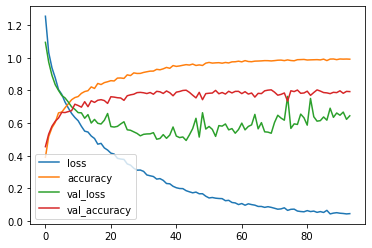

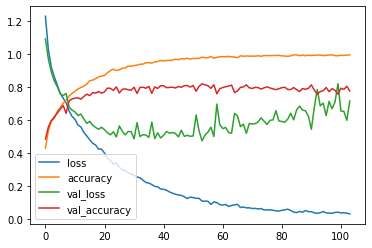

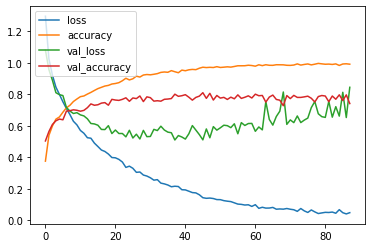

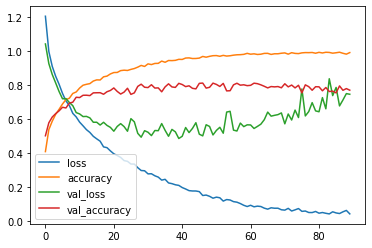

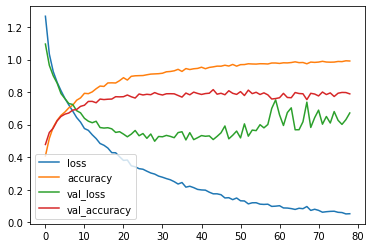

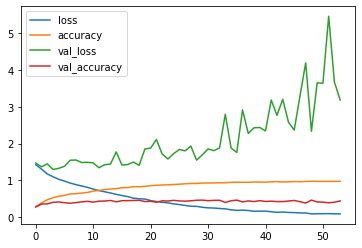

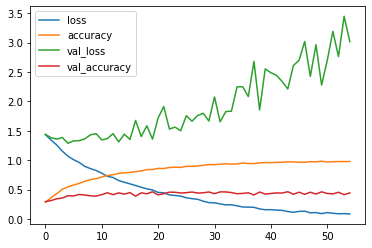

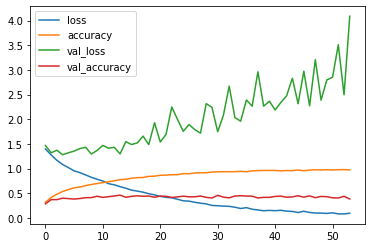

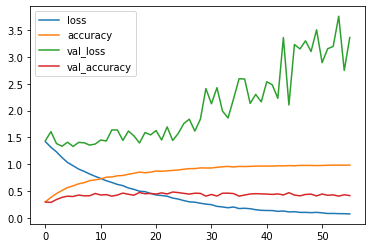

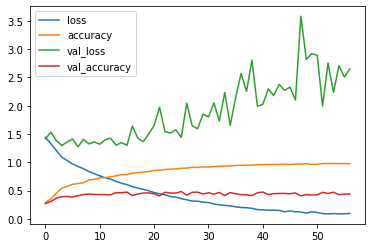

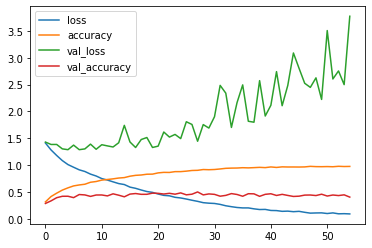

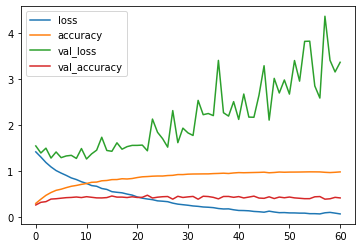

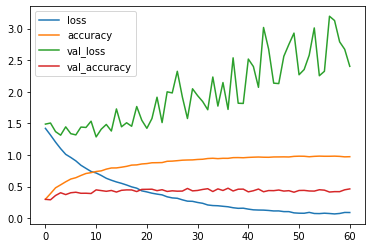

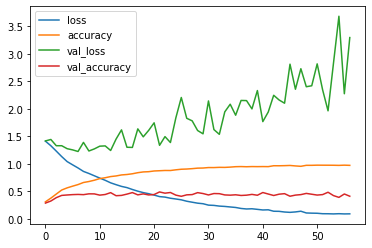

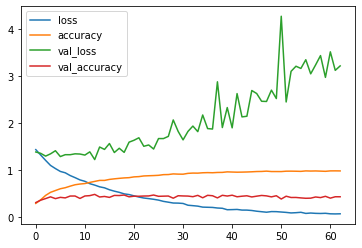

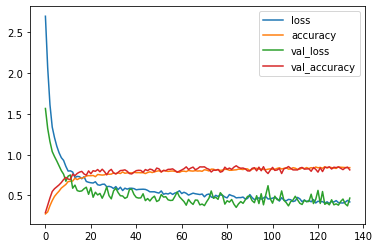

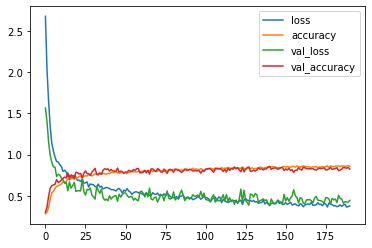

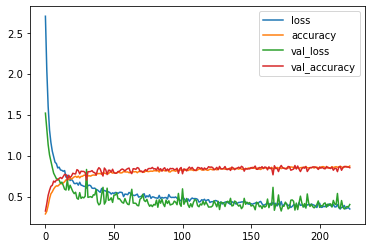

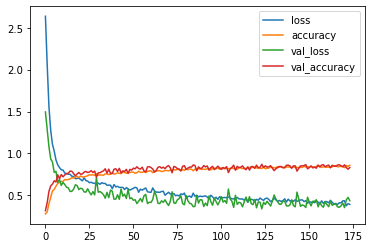

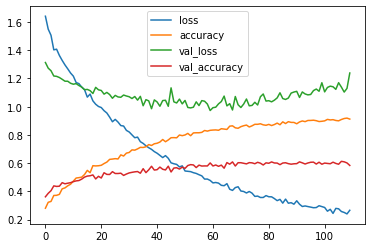

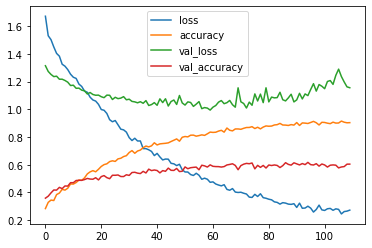

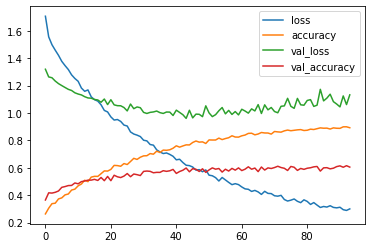

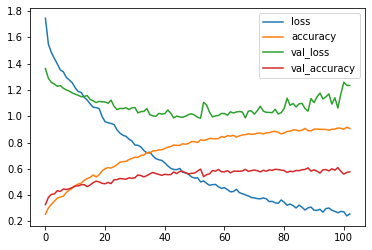

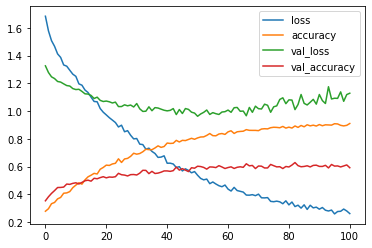

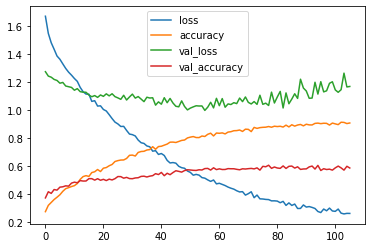

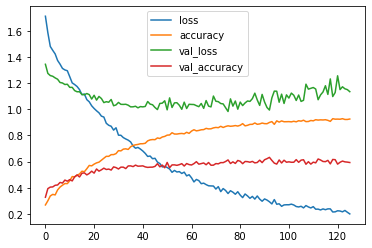

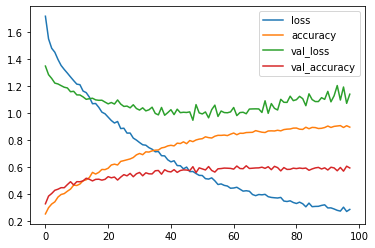

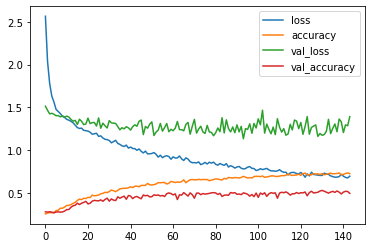

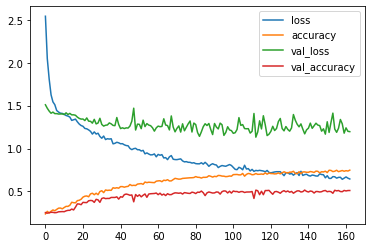

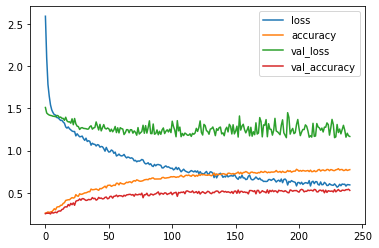

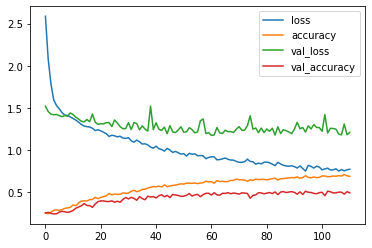

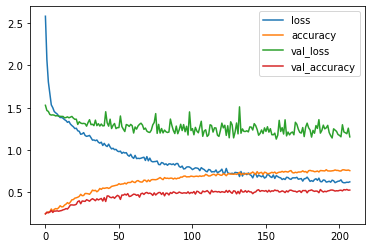

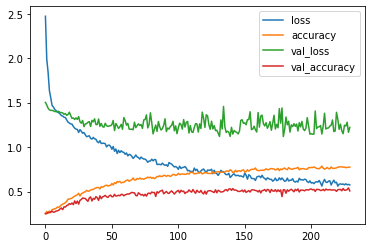

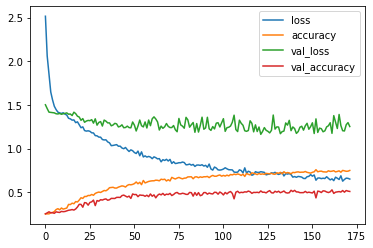

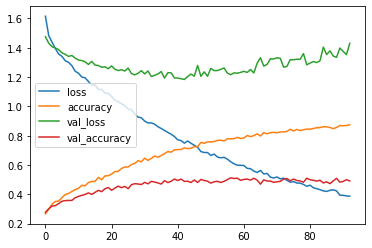

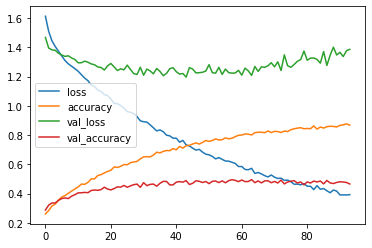

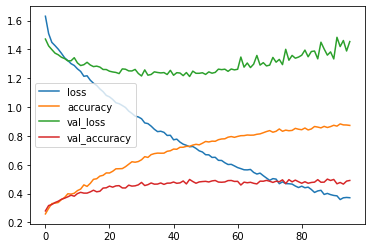

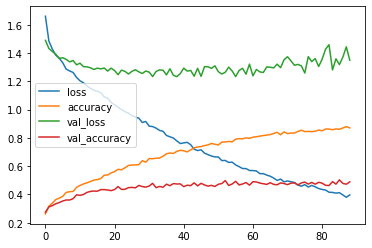

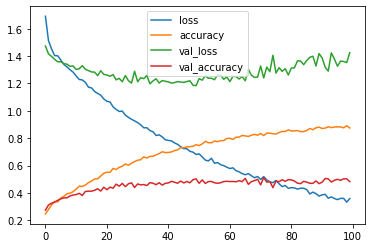

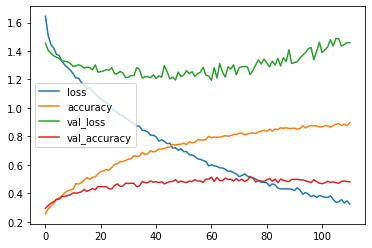

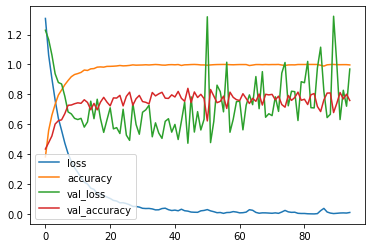

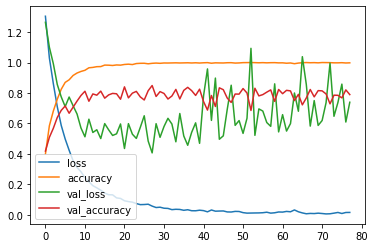

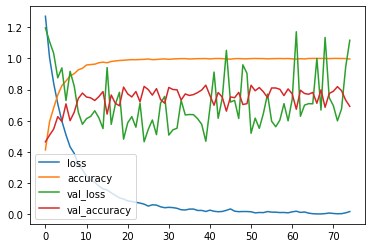

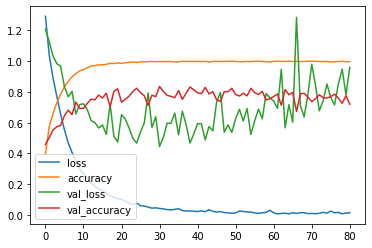

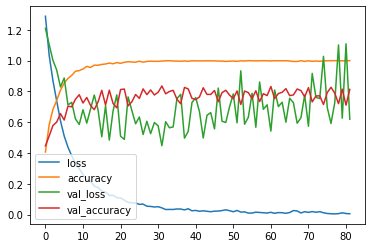

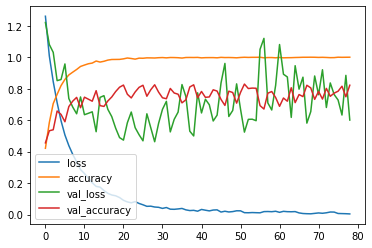

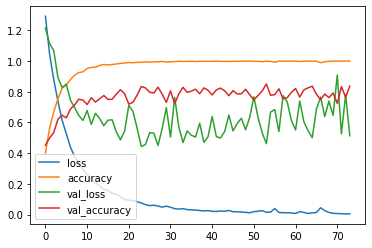

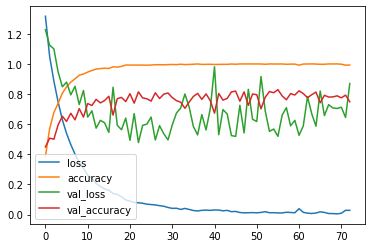

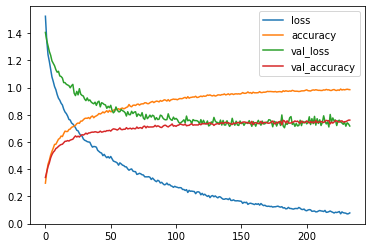

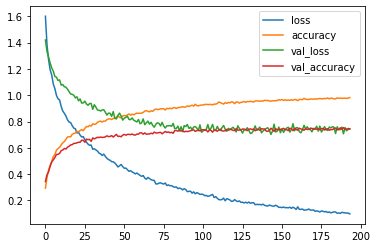

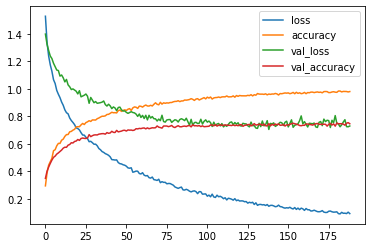

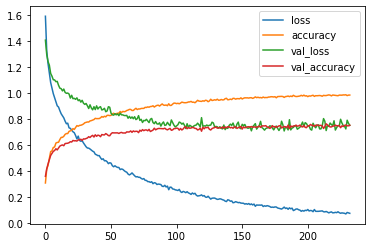

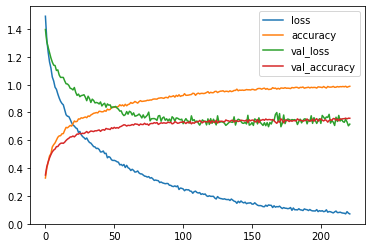

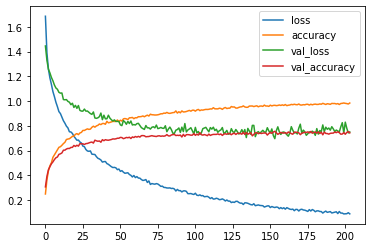

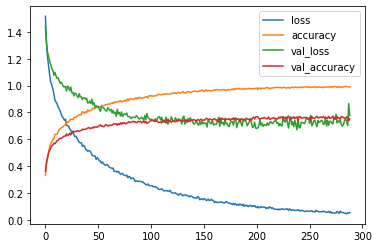

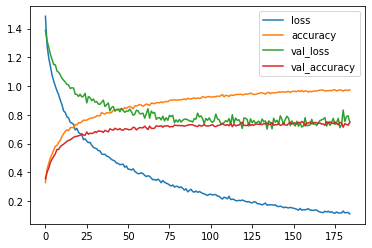

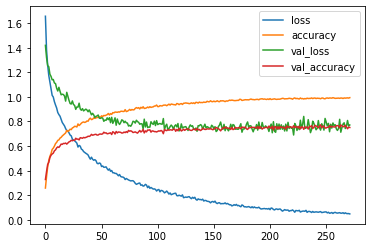

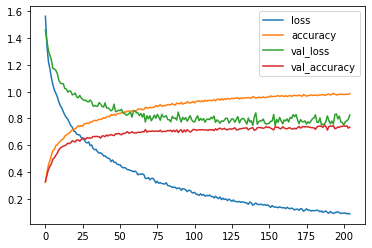

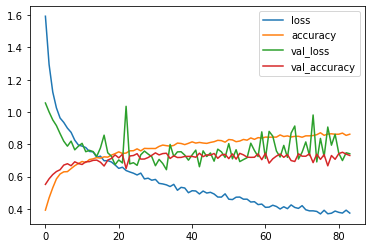

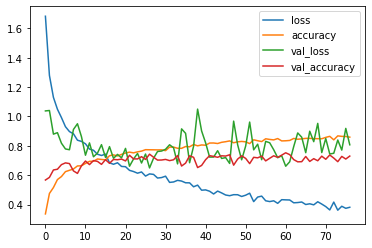

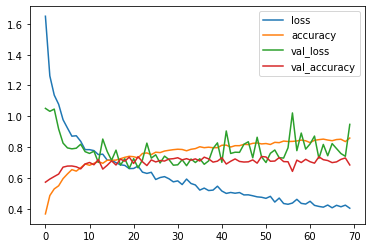

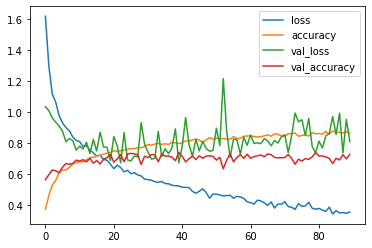

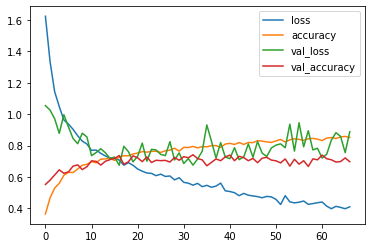

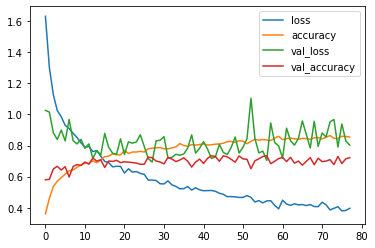

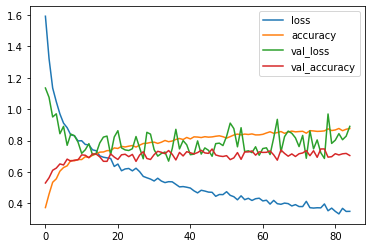

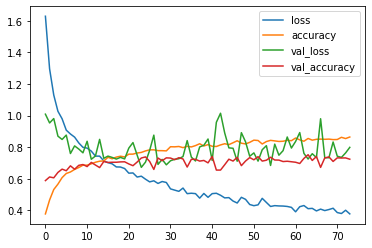

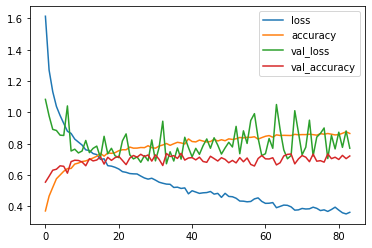

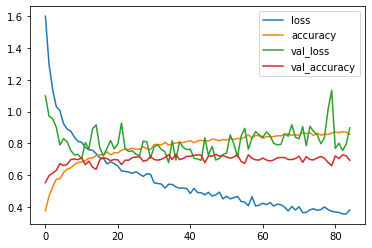

In [8]:
###Loop to train 10 tuned models for each subject and obtain the classification accuracies
tuned_accuracies = {}
for i in range(9):
    tuned_accuracies[str(i+1)] = []
print(tuned_accuracies)

for subject in tuned_accuracies:
    xT, yT= create_4sec_data(int(subject),'T')
    xE, yE= create_4sec_data(int(subject),'E')
    x_train, y_train = filt_and_seg(xT,yT, 500, 0.90)
    x_val, y_val = filt_and_seg(xE,yE, 500, 0.90)
    y_cat_train = to_categorical(y_train)
    y_cat_val = to_categorical(y_val)
    tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 500,
                     factor = 3,
                     directory=os.getcwd(),
                     project_name = 'TunedCNN-4class MI- BCI Comp S' + str(subject))  ##Load tuning results
    for test in range(10):
        model = build_tuned_model(tuner)
        early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        model.fit(x_train,y_cat_train, epochs = 400, validation_data=(x_val,y_cat_val), callbacks = [early_stop])
        metrics = pd.DataFrame(model.history.history)
        metrics.plot()

        predictions = model.predict_classes(x_val)

        print(classification_report(y_val,predictions,target_names=['Foot', 'Left Hand', 'Right Hand', 'Tongue'], digits=3))

        print(confusion_matrix(y_val,predictions))
        perf = model.evaluate(x_val, y_cat_val)
        tuned_accuracies[subject].append(perf[1])
        
    

In [9]:
###Classification accuracies of 10 tuned models trained for each subject's data
tuned_accuracies

{'1': [0.8036616444587708,
  0.8014520406723022,
  0.8055555820465088,
  0.8203914165496826,
  0.8197600841522217,
  0.8008207082748413,
  0.8058711886405945,
  0.7916666865348816,
  0.810606062412262,
  0.7970328330993652],
 '2': [0.405303031206131,
  0.3945707082748413,
  0.4015151560306549,
  0.3961489796638489,
  0.4109848439693451,
  0.4191919267177582,
  0.44286617636680603,
  0.4488636255264282,
  0.44381314516067505,
  0.48200756311416626],
 '3': [0.8607954382896423,
  0.8604797720909119,
  0.8743686676025391,
  0.8639520406723022,
  0.8645833134651184,
  0.8554292917251587,
  0.8791035413742065,
  0.8715277910232544,
  0.8734217286109924,
  0.8626893758773804],
 '4': [0.6016414165496826,
  0.6281565427780151,
  0.5988004803657532,
  0.5858585834503174,
  0.598169207572937,
  0.5978535413742065,
  0.6029040217399597,
  0.5817550420761108,
  0.6130050420761108,
  0.6025883555412292],
 '5': [0.499053031206131,
  0.5154671669006348,
  0.48895201086997986,
  0.5142045617103577,
  0

In [10]:
####To get the best accuracy achieved for each subject
best_accuracies = []
for subject in tuned_accuracies:
    best_accuracies.append(max(tuned_accuracies[subject]))

In [11]:
###Best classification accuracies obtained with the tuned models for each subject
best_accuracies

[0.8203914165496826,
 0.48200756311416626,
 0.8791035413742065,
 0.6281565427780151,
 0.5220959782600403,
 0.5135732293128967,
 0.8491161465644836,
 0.7667297720909119,
 0.7449495196342468]

In [12]:
##Mean classification accuracy for all subjects
np.mean(best_accuracies)

0.6895693010754056